This notebook include all modeling analysis and results. The notebook is divided into 3 parts: 

1. Exploratort analysis before optimization. 

2. Modeling pipeline and results used in the manuscript.

3. Addtional analysis with hierarchical modeling (not presented in the manuscript) and other models.

One can jump to the sections `Modeling Pipeline`, `Visualize prior estimates` and `Estimate prior by optimization` to see the results in the manuscript.

# Set up

In [1]:
import numpy as np
from scipy.special import i0
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import json
import glob

# from data_analysis.fit_bstrp import fit_bstrp
# import scipy.stats as st

# Load data
all_data = pd.read_csv('data/all_sel_data.csv')
all_estimates = pd.read_csv('data_analysis/pf_estimates/all_estimates.csv')
avg_estimates = pd.read_csv('data_analysis/pf_estimates/avg_estimates.csv')
stim_list = np.sort(all_data['standard_stim'].unique())
x_grid = np.load("data_analysis/model_estimates/x_grid.npy")

subs= ['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG']
n_sample = 1000

# Explorations before modeling
## Set up for explorations

In [2]:
from data_analysis.get_MAP import get_MAP
from data_analysis.fit_curves import FitCumNormal
from data_analysis.evaluate_prior import simul_estimate, each_loglik, each_sqrt_error
# from psychopy import data

test_data = all_data.query('subject == "s05"')
test_lh_data = test_data.query('condition == "LH"')
test_estimates = all_estimates.query('subject == "s5"')
test_lh_estimates = test_estimates.query('condition == "LH"')


test_analyis_path = "data_analysis/model_estimates/s5/s5"
test_lh_lik = [np.load(test_analyis_path + "_likelihoods_l.npy"), np.load(test_analyis_path + "_likelihoods_h.npy")]


## Explore the JND fit

In [3]:


def rect_sin0(x, a, b):
    """
    Rectified sine function.

    param x:    angle in degree
    param a:    amplitude
    param b:    offset
    """
    shift = -112  # peak at 112
    return a * abs(np.sin((x + shift) * np.pi / 180.0)) + b


def rect_sin1(x, shift, a, b):
    """
    Rectified sine function.

    param x:     angle in degree
    param shift: shift in degree
    param a:     amplitude
    param b:     offset
    """
    return a * abs(np.sin((x + shift) * np.pi / 180.0)) + b


def sin1(x, shift, a, b):
    """
    Sine function
    param x:     angle in degree
    param shift: shift in degree
    param a:     amplitude
    param b:     offset
    """
    return a * np.sin((x + shift) * np.pi / 90.0) + b


# def sin_mixed(x, s1, s2, a1, a2, b):
#     """
#     Mixed sine function
#     param x:       angle in degree
#     param s1, s2:  shifts in degree
#     param a1, a2:  amplitudes
#     param b:  offsets
#     """
#     return a1 * np.sin((x + s1) * np.pi / 90.0) + a2 * np.sin((x + s2) * np.pi / 180.0) + b

def sin_mixed(x, s1, s2, a, b):
    """
    Mixed sine function
    param x:       angle in degree
    param s1, s2:  shifts in degree
    param a:  amplitudes
    param b:  offsets
    """
    return a * (np.sin((x + s1) * np.pi / 90.0) + np.sin((x + s2) * np.pi / 180.0)) + b

/tmp/ipykernel_5844/4208701411.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[6, 3].set_xticklabels(model_labels, rotation=90)
/tmp/ipykernel_5844/4208701411.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[6, 4].set_xticklabels(model_labels, rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


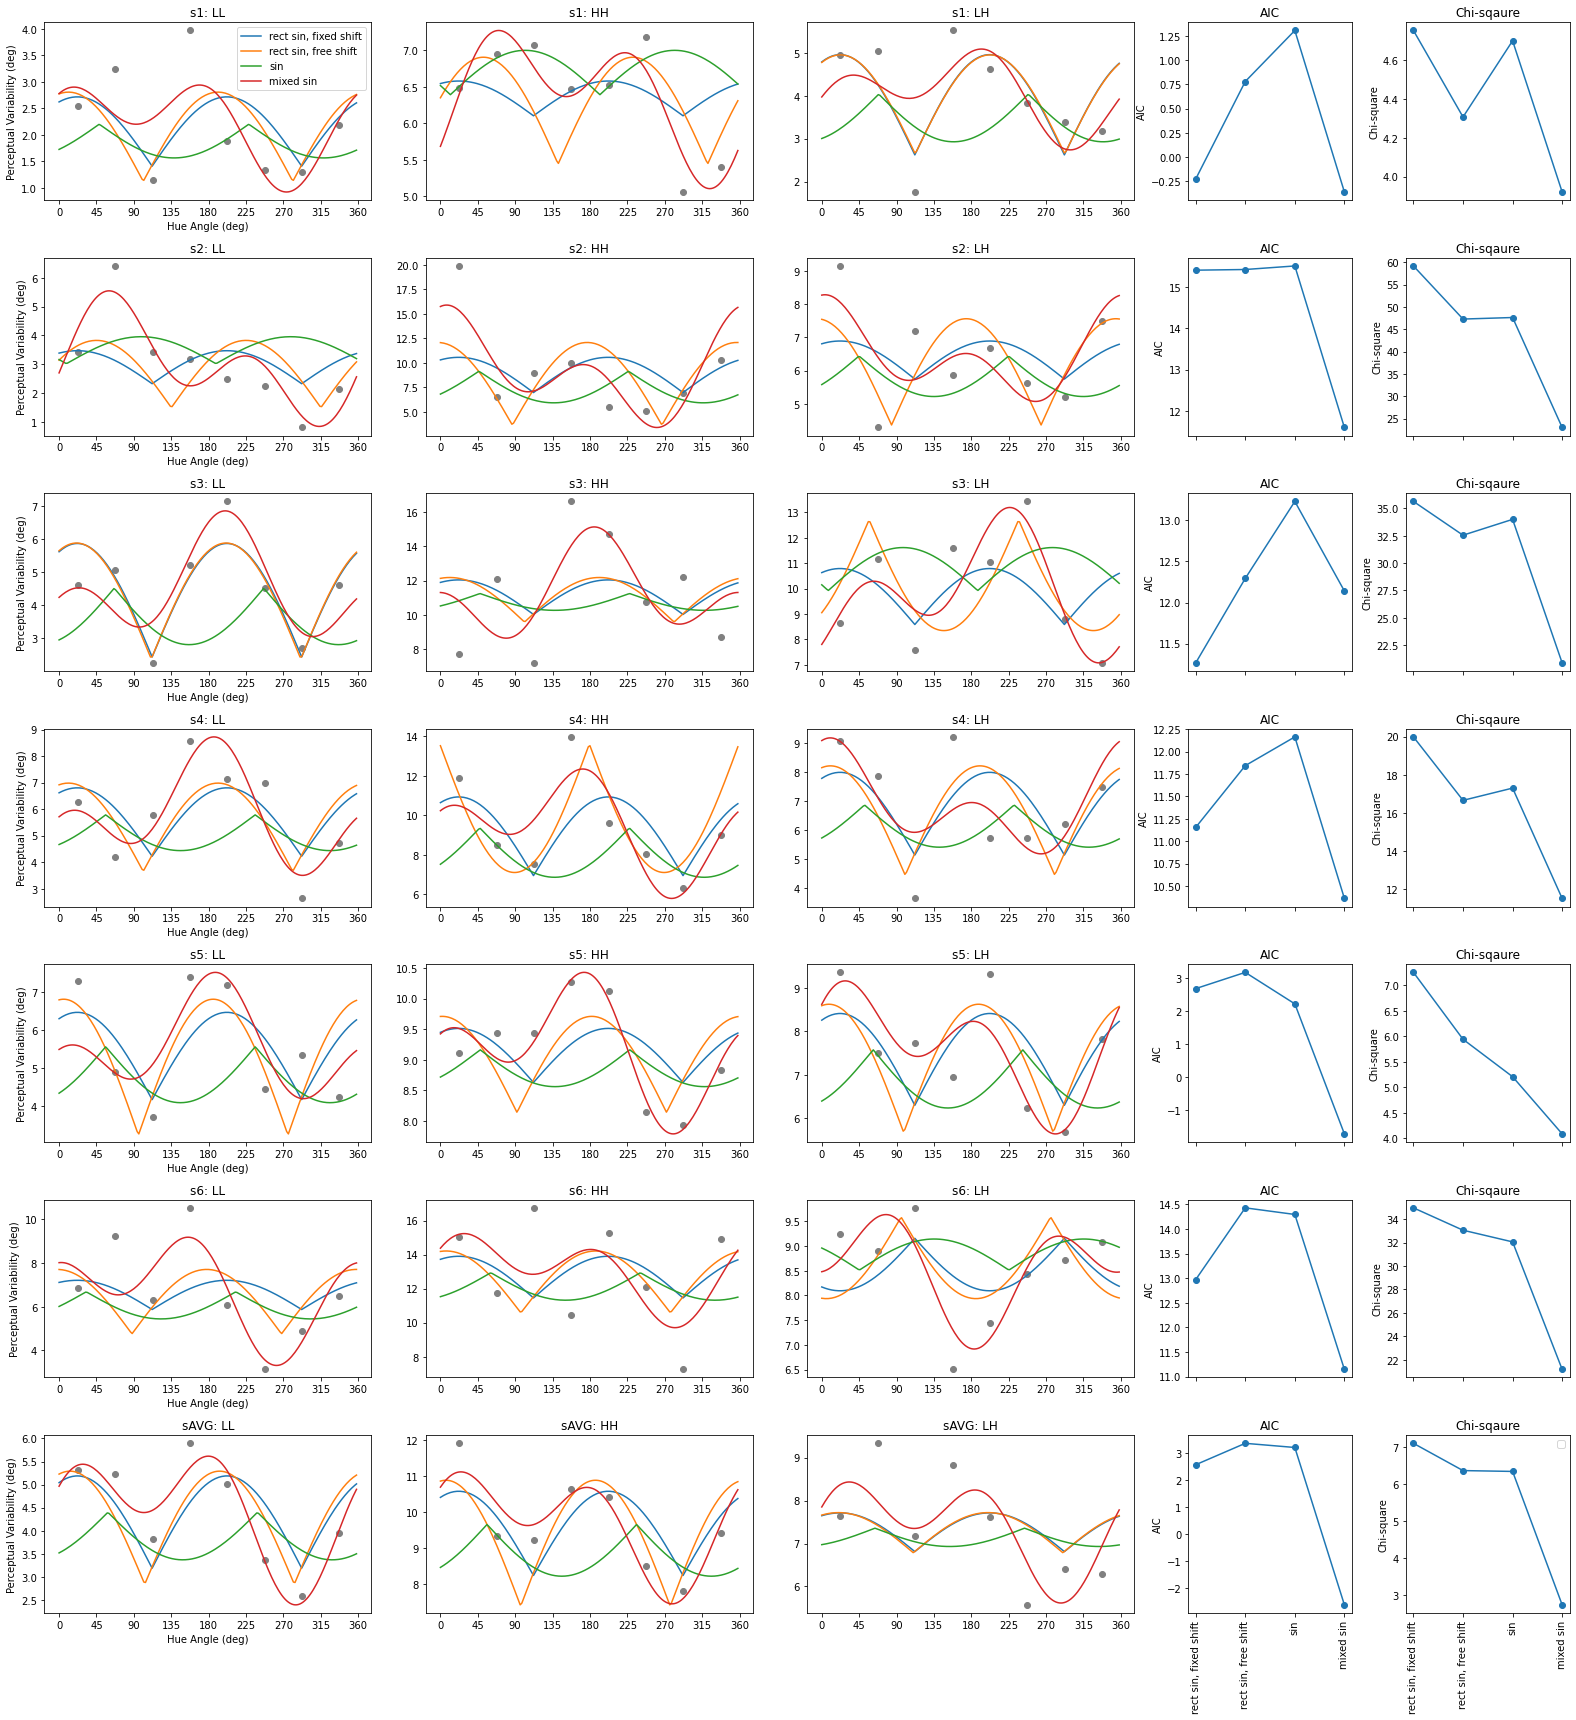

In [4]:
from lmfit import Model

# test_estimates = all_estimates.query('subject == "s3"')

estimates = pd.concat([all_estimates, avg_estimates], ignore_index=True)

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(22, 24), gridspec_kw={'width_ratios': [2, 2, 2, 1, 1]})
for sid, sub in enumerate(estimates['subject'].unique()):

    model_labels = ['rect sin, fixed shift', 'rect sin, free shift', 'sin', 'mixed sin']

    aics = np.zeros((len(model_labels), 3))
    bics = np.zeros((len(model_labels), 3))
    chis = np.zeros((len(model_labels), 3))

    for idx, cond in enumerate(['LL', 'HH', 'LH']):
        test_estimates = estimates.query('subject == @sub')

        hues = test_estimates.query('condition == @cond')['Hue Angle']
        jnds = test_estimates.query('condition == @cond')['JND']

        axes[sid, idx].scatter(hues, jnds, color='gray')


        m0 = Model(rect_sin0)
        res0 = m0.fit(jnds, x=hues, a=1, b=0)
        pars0 = res0.params.valuesdict().values()
        axes[sid, idx].plot(x_grid, rect_sin0(x_grid, *pars0), '-',  label=model_labels[0])

        m1 = Model(rect_sin1)
        res1 = m1.fit(jnds, x=hues, shift=-112, a=1, b=0)
        pars1 = res1.params.valuesdict().values()
        axes[sid, idx].plot(x_grid, rect_sin1(x_grid, *pars1), '-',  label=model_labels[1])

        m2 = Model(sin1)
        res2 = m2.fit(jnds, x=hues, shift=-45, a=1, b=0)
        pars2 = res2.params.valuesdict().values()
        axes[sid, idx].plot(x_grid, rect_sin1(x_grid, *pars2), '-',  label=model_labels[2])

        m3 = Model(sin_mixed)
        # res3 = m3.fit(jnds, x=hues, s1=45, s2=90, a1=1, a2=1, b=0)
        res3 = m3.fit(jnds, x=hues, s1=45, s2=90, a=1, b=0)
        pars3 = res3.params.valuesdict().values()
        axes[sid, idx].plot(x_grid, sin_mixed(x_grid, *pars3), '-',  label=model_labels[3])
        
        axes[sid, idx].set_title(f"{sub}: {cond}")
        axes[sid, idx].set_xticks(np.arange(0, 360+45, 45))
        axes[sid, 0].set_xlabel('Hue Angle (deg)')
        axes[sid, 0].set_ylabel('Perceptual Variability (deg)')


        aics[:, idx] = np.array([res0.aic, res1.aic, res2.aic, res3.aic])
        # bics[:, idx] = np.array([res0.bic, res1.bic, res2.bic, res3.bic])
        chis[:, idx] = np.array([res0.chisqr, res1.chisqr, res2.chisqr, res3.chisqr])
        # gof[:, idx] = np.array([res0.redchi, res1.redchi, res2.redchi])


    axes[sid, 3].plot(model_labels, np.mean(aics, axis=1), '-o')
    axes[sid, 4].plot(model_labels, np.mean(chis, axis=1), '-o')

    axes[sid, 3].set_title("AIC")
    axes[sid, 4].set_title("Chi-sqaure")

    axes[sid, 3].set_ylabel('AIC')
    axes[sid, 4].set_ylabel('Chi-square')
    axes[sid, 3].set_xticklabels([])
    axes[sid, 4].set_xticklabels([])


axes[6, 3].set_xticklabels(model_labels, rotation=90)
axes[6, 4].set_xticklabels(model_labels, rotation=90)
axes[0, 0].legend()

plt.legend()
plt.tight_layout()

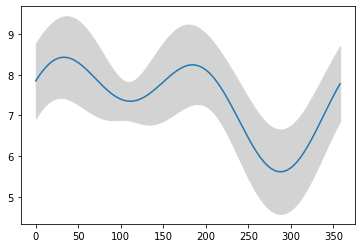

In [42]:
# higher = res3.eval_uncertainty(x=x_grid, params=res3.params, sigma=.95)
dely = res3.eval_uncertainty(x=x_grid, sigma=.68)

plt.plot(x_grid, res3.eval(x=x_grid, params=res3.params))

plt.fill_between(x_grid, res3.eval(x=x_grid, params=res3.params)-dely, res3.eval(x=x_grid, params=res3.params)+dely, color='lightgray')

## Explore the shape of prior 

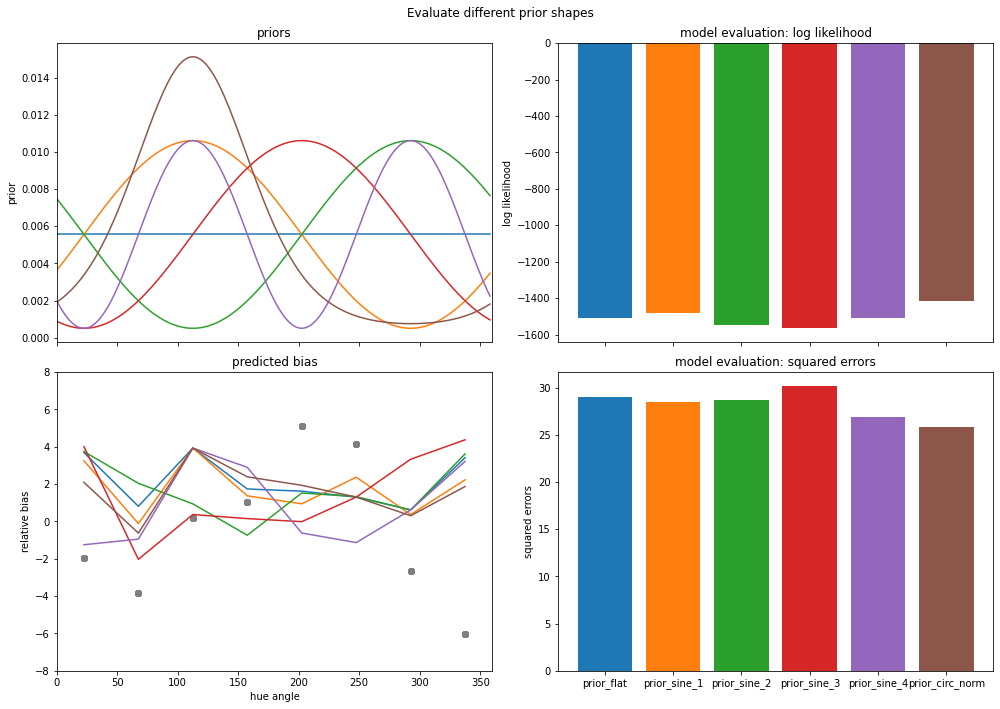

In [6]:
# Define priors
def prior_uniform(x):
    y = 1./(len(x_grid))
    return np.repeat(y, len(x_grid))

def prior_sine_1(x):
    y = np.sin((x - 112.5 + 90) * np.pi / 180.0) + 1.1 
    return y/sum(y)

def prior_sine_2(x):
    y = np.sin((x - 292.5 + 90) * np.pi / 180.0) + 1.1  
    return y/sum(y)

def prior_sine_3(x):
    y = np.sin((x - 202.5 + 90) * np.pi / 180.0) + 1.1
    return y/sum(y)

def prior_sine_2peak(x):
    y = np.sin((x - 112.5 + 45.0) * 2 * np.pi / 180.0) + 1.1
    return y/sum(y)

# def prior_circ_norm(x):
#     mu_rad =  112.5 / 180. * np.pi
#     # mu_rad = -0.20265825
#     kappa = 1.5
#     x_rad = x / 180. * np.pi
#     y = np.exp(kappa * np.cos(x_rad - mu_rad)) / (2 * np.pi * i0(kappa)) + 0.04
#     return y/sum(y)

def prior_circ_norm(x):
    mu, kappa, offset = 112.5 / 180. * np.pi, 1.5, 0
    # mu, kappa, offset = 1.8, 2.4, 0
    x_rad = x / 180. * np.pi
    y = np.exp(kappa * np.cos(x_rad - mu)) / (2 * np.pi * i0(kappa)) + offset
    return y/sum(y)

prior_lists = [prior_uniform(x_grid), 
               prior_sine_1(x_grid), prior_sine_2(x_grid), prior_sine_3(x_grid), prior_sine_2peak(x_grid), 
               prior_circ_norm(x_grid)]
prior_names = ['prior_flat', 
               'prior_sine_1', 'prior_sine_2', 'prior_sine_3', 'prior_sine_4', 
               'prior_circ_norm']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharex='col')

for pr, name in zip(prior_lists, prior_names):
    simul_res, simul_fit = simul_estimate(test_lh_data, pr, test_lh_lik)
    plt.suptitle("Evaluate different prior shapes")

    # 1. plot priors
    ax[0, 0].set_title('priors')
    ax[0, 0].plot(x_grid, pr, label=name)
    ax[0, 0].set_ylabel('prior')
    
    # 2. plot predicited relative bias versus true data
    ax[1, 0].set_title('predicted bias')
    ax[1, 0].scatter(stim_list, test_lh_estimates['PSE'], color='gray', label='true data')
    ax[1, 0].plot(stim_list, [s.params[0] for s in simul_fit.values], label=name)
    ax[1, 0].set_xlim([0, 360])
    ax[1, 0].set_ylim([-8, 8])
    ax[1, 0].set_xlabel('hue angle')
    ax[1, 0].set_ylabel('relative bias')

    # 3. plot log likelihood
    ax[0, 1].set_title('model evaluation: log likelihood')
    ax[0, 1].bar(name, np.sum(each_loglik(test_lh_data, simul_res, simul_fit)))
    ax[0, 1].set_ylabel('log likelihood')

    # 4. plot squared errors
    ax[1, 1].set_title('model evaluation: squared errors')
    ax[1, 1].bar(name, np.sum(each_sqrt_error(simul_res, simul_fit)))
    ax[1, 1].set_ylabel('squared errors')
plt.tight_layout()
plt.show()
    

## Explore the Sine function parameters

Given $(non-normed) \ prior  = A * sin(\theta + \phi) + A + C $, test how the values of one parameter influence fitting evaluation while controling the other two parameters.

Again, squared errors and likekihoods used to evaluate. 

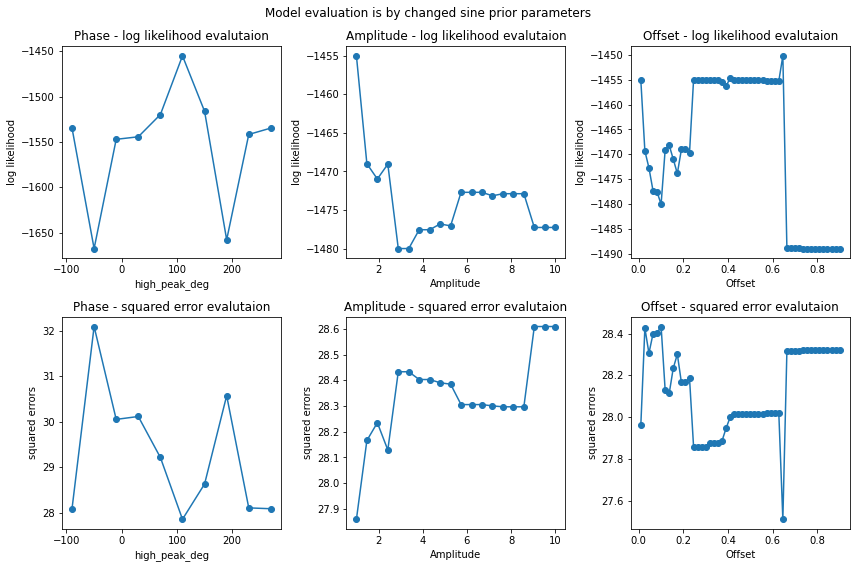

In [14]:
def prior_unknown_phase(phi):
    y = 1 * np.sin(x_grid * np.pi / 180 + phi) + 1 + 0.3
    return y/sum(y)

def prior_unknown_amp(a):
    y = a * np.sin((x_grid - 112.5 + 90) * np.pi / 180.0) + a + 0.3
    return y/sum(y)

def prior_unknown_offset(c):
    y = 1 *  np.sin((x_grid - 112.5 + 90) * np.pi / 180.0) + 1 + c
    return y/sum(y)

def eval_unknown_pars(par_vals, func):
    sqrt_error = []
    loglik = []
    priors = [func(p) for p in par_vals]

    for p in priors:
        r, f = simul_estimate(test_lh_data, p, test_lh_lik)
        sqrt_error.append(np.sum(each_sqrt_error(r, f)))
        loglik.append(np.sum(each_loglik(test_lh_data, r, f)))
    return sqrt_error, loglik

phi_s = np.linspace(-np.pi, np.pi, 10)
high_peak_deg = (np.pi/2 - phi_s) / np.pi * 180 
sqrt_error_phi, loglik_phi = eval_unknown_pars(phi_s, prior_unknown_phase)
a_vals = np.linspace(1, 10, 20)
sqrt_error_amp, loglik_amp = eval_unknown_pars(a_vals, prior_unknown_amp)
c_vals = np.linspace(0.01, 0.9, 50)
sqrt_error_offset, loglik_offset = eval_unknown_pars(c_vals, prior_unknown_offset)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[12, 8])

plt.suptitle("Model evaluation is by changed sine prior parameters")

ax[0, 0].set_title("Phase - log likelihood evalutaion")
ax[0, 0].plot(high_peak_deg, loglik_phi, '-o')
ax[0, 0].set_ylabel('log likelihood')
ax[0, 0].set_xlabel('high_peak_deg')
ax[1, 0].set_title("Phase - squared error evalutaion")
ax[1, 0].plot(high_peak_deg, sqrt_error_phi, '-o')
ax[1, 0].set_ylabel('squared errors')
ax[1, 0].set_xlabel('high_peak_deg')

ax[0, 1].set_title("Amplitude - log likelihood evalutaion")
ax[0, 1].plot(a_vals, loglik_amp, '-o')
ax[0, 1].set_ylabel('log likelihood')
ax[0, 1].set_xlabel('Amplitude')
ax[1, 1].set_title("Amplitude - squared error evalutaion")
ax[1, 1].plot(a_vals, sqrt_error_amp, '-o')
ax[1, 1].set_ylabel('squared errors')
ax[1, 1].set_xlabel('Amplitude')

ax[0, 2].set_title("Offset - log likelihood evalutaion")
ax[0, 2].plot(c_vals, loglik_offset, '-o')
ax[0, 2].set_ylabel('log likelihood')
ax[0, 2].set_xlabel('Offset')
ax[1, 2].set_title("Offset - squared error evalutaion")
ax[1, 2].plot(c_vals, sqrt_error_offset, '-o')
ax[1, 2].set_ylabel('squared errors')
ax[1, 2].set_xlabel('Offset')

plt.tight_layout()
plt.show()

# Modeling Pipeline

In [2]:
# model_path = "data_analysis/model_estimates"
model_path = "data_analysis/model_estimates_v2"  # final version in the manuscript
# model_path = "data_analysis/model_estimates_v2_test"


## 1. Fit JNDs, simulate trials, estimate likelihood functions.
Make sure the scripts functions before running...
Estimates will be saved in `data_analysis/model_estimates/s0/`:
- `s0_jnd_fit_l.pickle`, `s0_jnd_fit_h.pickle`
- `s0_mat_l.npy`, `s0_mat_h.npy`
- `s0_mat_edges_l.npy`, `s0_mat_edges_h.npy`
- `s0_samples_l.npy`, `s0_samples_h.npy`
- `s0_likelihoods_l.npy`, `s0_likelihoods_h.npy`


In [ ]:
"""
from data_analysis.estimate_likelihood import estimate_lik

# For single sub

# sub_list = ['s1', 's2', 's4', 's5', 's6']
# for sub in sub_list:
#     sub_in_data = sub[0] + '0' + sub[1]                  # different naming way in data 
#     sub_data = all_data.query('subject == @sub_in_data')
#     sub_estimates = all_estimates.query('subject == @sub')
#     sub_path = f"{model_path}/{sub}/{sub}"
#     if not os.path.exists(f"{model_path}/{sub}"):
#         os.makedirs(f"{model_path}/{sub}")
#     estimate_lik(sub_data, sub_estimates, x_grid, n_sample, sub_path)


# For average sub
# sub_path = f"{model_path}/sAVG/sAVG"
# if not os.path.exists(f"{model_path}/sAVG"):
#     os.makedirs(f"{model_path}/sAVG")
# estimate_lik(all_data, avg_estimates, x_grid, n_sample, sub_path)
"""

## 2. Estimate prior by optimization
Load likelihood estimates in step 1 and estimate priors.

Estimates will be save in `data_analysis/model_estimates/s0/s0_shape_prior_estm.json`.

### Sine-shaped prior

In [ ]:
"""
from data_analysis.estimate_prior import run_estimation

subs = ['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG']
run_estimation(subs, func_type='sine')

# run_estimation(subs, func_type='sine', n_btrp=100)  # with bootstrapping
"""

### Bell-shaped prior

In [4]:
"""
from data_analysis.estimate_prior import run_estimation

# run_estimation(subs, func_type='gauss')
run_estimation(['sAVG'], func_type='gauss', model_path=model_path, n_btrp=100)

# run_estimation(subs, func_type='gauss', n_btrp=100)  # with bootstrapping
"""

differential_evolution step 1: f(x)= 6956.32
differential_evolution step 2: f(x)= 6956.32
differential_evolution step 3: f(x)= 6956.32
differential_evolution step 4: f(x)= 6956.32
     fun: 6956.321697629081
 message: 'Optimization terminated successfully.'
    nfev: 153
     nit: 4
 success: True
       x: array([1.70726624, 1.46918544])
differential_evolution step 1: f(x)= 7028.2
differential_evolution step 2: f(x)= 6968.49
differential_evolution step 3: f(x)= 6960.61
differential_evolution step 4: f(x)= 6960.61
differential_evolution step 5: f(x)= 6937.64
     fun: 6937.641134455318
 message: 'Optimization terminated successfully.'
    nfev: 183
     nit: 5
 success: True
       x: array([1.98309249, 1.99340374])
differential_evolution step 1: f(x)= 6988.7
differential_evolution step 2: f(x)= 6988.7


### Merge priors into a csv

In [47]:
"""
# For sine priors
sine_priors_list = []
for i_sub, sub in enumerate(['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG']):
    sub_path = f"{model_path}/{sub}/{sub}"
    with open (sub_path + '_sine_prior_optm.json') as f:
        sub_prior = json.load(f)["prior"]
    priors_df = pd.DataFrame({'sub':sub, 'Hue Angle': x_grid, 'Prior': sub_prior})
    sine_priors_list.append(priors_df)

sine_priors_df = pd.concat(sine_priors_list)
# sine_priors_df.to_csv(f"{model_path}/sine_prior.csv")

"""

"""
# For sine priors with two peaks
sine_2peak_priors_list = []
for i_sub, sub in enumerate(['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG']):
    sub_path = f"{model_path}/{sub}/{sub}"
    with open (sub_path + '_sine_2peak_prior_optm.json') as f:
        sub_prior = json.load(f)["prior"]
    priors_df = pd.DataFrame({'sub':sub, 'Hue Angle': x_grid, 'Prior': sub_prior})
    sine_2peak_priors_list.append(priors_df)

sine_priors_df = pd.concat(sine_2peak_priors_list)
# sine_priors_df.to_csv(f"{model_path}/sine_2peak_prior.csv")
"""

"""
# For gauss priors with two peaks
gauss_2peak_priors_list = []
for i_sub, sub in enumerate(['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG']):
    sub_path = f"{model_path}/{sub}/{sub}"
    with open (sub_path + '_gauss_2peak_prior_optm.json') as f:
        sub_prior = json.load(f)["prior"]
    priors_df = pd.DataFrame({'sub':sub, 'Hue Angle': x_grid, 'Prior': sub_prior})
    gauss_2peak_priors_list.append(priors_df)

sine_priors_df = pd.concat(gauss_2peak_priors_list)
# sine_priors_df.to_csv(f"{model_path}/gauss_2peak_prior.csv")
"""


# For gauss priors
gauss_priors_list = []
# for i_sub, sub in enumerate(['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG']):
for i_sub, sub in enumerate(['s3', 'sAVG']):
    sub_path = f"{model_path}/{sub}/{sub}"
    with open (sub_path + '_gauss_prior_optm.json') as f:
        sub_prior = json.load(f)["prior"]
    priors_df = pd.DataFrame({'sub':sub, 'Hue Angle': x_grid, 'Prior': sub_prior})
    gauss_priors_list.append(priors_df)

gauss_priors_df = pd.concat(gauss_priors_list)
gauss_priors_df.to_csv(f"{model_path}/gauss_prior.csv")

# For gaussian priors (bootstrapping)
import glob
def load_btrp_priors(sub, func_type):
    file_pattern = f"{model_path}/{sub}/{sub}_{func_type}_prior_btrp100.json"
    json_file = glob.glob(file_pattern)
    if len(json_file) > 1:
        raise ValueError("More than one bootstrapping results is found!")
    else:
        json_file = json_file[0]
    with open (json_file) as f:
        btrp_priors = np.array([json.loads(line) for line in f])
    return btrp_priors

priors_list = []
# for sub in subs:  
for sub in ['s3', 'sAVG']:    
    btrp_priors = load_btrp_priors(sub, 'gauss')
    priors_df = pd.concat([pd.DataFrame({'sub':sub, 'Hue Angle': x_grid, 'Prior': bp['prior']}) for bp in btrp_priors])
    priors_list.append(priors_df)
sub_btrp_priors = pd.concat(priors_list)
sub_btrp_priors.to_csv(f'{model_path}/gauss_prior_btrp100.csv')

# Average bootstrapping gaussian priors
def prior_circ_gaussian(x, mu, kappa):
    """
    A von Mises model for the prior.

    :param pars:
    :return: normalized prior
    """
    x_rad = x / 180. * np.pi
    y = np.exp(kappa * np.cos(x_rad - mu)) / (2 * np.pi * i0(kappa))
    return y/sum(y)
"""
mean_btrp_priors = sub_btrp_priors.groupby(['sub', 'Hue Angle']).mean().reset_index()
# mean_btrp_priors.to_csv(f'{model_path}/gauss_prior_btrp100_mean.csv')
"""

"\nmean_btrp_priors = sub_btrp_priors.groupby(['sub', 'Hue Angle']).mean().reset_index()\n# mean_btrp_priors.to_csv(f'{model_path}/gauss_prior_btrp100_mean.csv')\n"

In [4]:
# for prior estimates without bootstrapping
gauss_priors_list = []
for i_sub, sub in enumerate(['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG']):
    sub_path = f"{model_path}/{sub}/{sub}"
    with open (sub_path + '_gauss_prior_optm.json') as f:
        sub_prior = json.load(f)["prior"]
    priors_df = pd.DataFrame({'sub':sub, 'Hue Angle': x_grid, 'Prior': sub_prior})
    gauss_priors_list.append(priors_df)

gauss_priors_df = pd.concat(gauss_priors_list)
gauss_priors_df.to_csv(f"{model_path}/gauss_prior.csv")

### Merge parameters of the prior into a csv

In [3]:
# For gaussian priors (bootstrapping)

def load_btrp_priors(sub, func_type):
    file_pattern = f"{model_path}/{sub}/{sub}_{func_type}_prior_btrp1000.json"

    # file_pattern = f"{model_path}/{sub}/{sub}_{func_type}_prior_btrp100.json"
    # file_pattern = f"data_analysis/model_estimates_v2/{sub}/{sub}_{func_type}_prior_btrp100.json"

    json_file = glob.glob(file_pattern)
    if len(json_file) > 1:
        raise ValueError("More than one bootstrapping results is found!")
    else:
        json_file = json_file[0]
    with open (json_file) as f:
        btrp_priors = np.array([json.loads(line) for line in f])
    return btrp_priors
    
prior_pars_list = []
# for sub in subs:
# for sub in ['s3', 'sAVG']:   
for sub in ['s3']:
    btrp_priors = load_btrp_priors(sub, 'gauss')
    prior_pars_df = pd.concat([pd.DataFrame({'sub':sub, 'mu': [bp['params'][0]], 'kappa':[bp['params'][1]]}) for bp in btrp_priors])
    # prior_pars_df = 
    prior_pars_list.append(prior_pars_df)
sub_btrp_prior_pars = pd.concat(prior_pars_list).reset_index()

sub_btrp_prior_pars['mu_deg'] = sub_btrp_prior_pars['mu'].apply(np.rad2deg)

# sub_btrp_prior_pars.to_csv(f'{model_path}/gauss_prior_param_btrp100.csv', index=False)
sub_btrp_prior_pars

,index,sub,mu,kappa,mu_deg
0,0,s3,2.246604,2.138542,128.720912
1,0,s3,2.309011,1.910527,132.296594
2,0,s3,2.267238,2.090293,129.903177
3,0,s3,2.613291,3.917173,149.730518
4,0,s3,2.263564,2.062406,129.692672
...,...,...,...,...,...
995,0,s3,2.631926,4.069374,150.798272
996,0,s3,2.334019,1.969942,133.729423
997,0,s3,2.231815,2.140925,127.873574
998,0,s3,2.355871,1.999430,134.981444


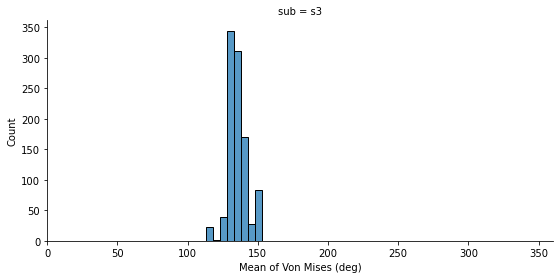

In [4]:
# plot distribution of prior parameters

g = sns.FacetGrid(data=sub_btrp_prior_pars.query("sub in ['s3', 'sAVG']"), col='sub', height=4, aspect=2)
g.map(sns.histplot, 'mu_deg', binwidth=5)
g.set(xlim=[0, 360], xlabel='Mean of Von Mises (deg)')

# plt.savefig(f'{model_path}/gauss_prior_btrp100_mu_dist.pdf')

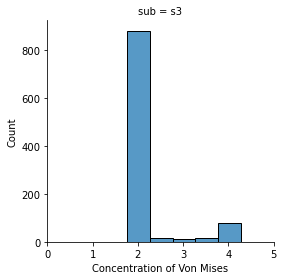

In [5]:
g = sns.FacetGrid(data=sub_btrp_prior_pars.query("sub in ['s3', 'sAVG']"), col='sub', height=4, aspect=1)
g.map(sns.histplot, 'kappa', binwidth=.5)
g.set(xlabel='Concentration of Von Mises', xlim=(0, 5))
# plt.savefig(f'{model_path}/gauss_prior_btrp100_kappa_dist.pdf')

In [ ]:
def prior_circ_gaussian(x, mu, kappa):
    """
    A von Mises model for the prior.

    :param pars:
    :return: normalized prior
    """
    x_rad = x / 180. * np.pi
    y = np.exp(kappa * np.cos(x_rad - mu)) / (2 * np.pi * i0(kappa))
    return y/sum(y)/2

fig, ax = plt.subplots(figsize=(12, 4), ncols=2, sharey=True)
for isub, sub in enumerate(['s3', 'sAVG']):

# fig, ax = plt.subplots(figsize=(6*5, 4), ncols=5, sharey=True)
# for isub, sub in enumerate(['s1', 's2', 's4', 's5', 's6']):

    priors = [prior_circ_gaussian(x_grid, p[0], p[1]) for p in sub_btrp_prior_pars.query("sub ==@sub")[['mu', 'kappa']].to_numpy()]
    with open (f'{model_path}/{sub}/{sub}_gauss_prior_optm.json') as f:
        single_prior = json.load(f)["prior"]
    [ax[isub].plot(x_grid, p, alpha=.4) for p in priors]
    ax[isub].fill_between(x_grid, np.mean(priors, axis=0)-np.std(priors, axis=0), 
                                np.mean(priors, axis=0)+np.std(priors, axis=0), color='lightgray')
    ax[isub].plot(x_grid, np.mean(priors, axis=0), color='black', ls='--')
    ax[isub].plot(x_grid, np.array(single_prior)/2, color='black')
    ax[isub].set_title(sub)
    # ax[isub].set_ylim(0, 0.015)
[a.set_xticks(np.arange(0, 360+90, 90)) for a in ax]
[a.set_xlabel("Hue Angle (deg)") for a in ax]
[a.set_ylabel("Probability") for a in ax]
# plt.savefig(f'{model_path}/gauss_prior_btrp100_each_prior.pdf')
plt.plot()


# Visualize prior estimates

In [6]:
import json
import seaborn as sns
# from data_analysis.estimate_prior import EstimatePrior
sub_list = ['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG']
sub_colors = sns.color_palette("husl", len(sub_list))
stim_list = np.linspace(22.5, 337.5, 8, endpoint=True)

## Sine-shaped Prior

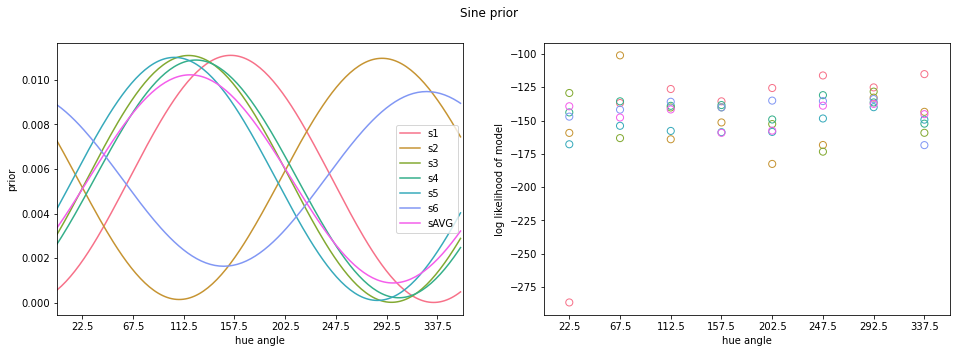

In [21]:

# prior_type = '_sine_2peak_prior'
prior_type = '_sine_prior'


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plt.suptitle("Sine prior")

params_list = []
optm_prior_list = []
loglik_list = []
for idx, sub in enumerate(sub_list):
    prior_path = f"{model_path}/{sub}/{sub}{prior_type}_optm.json"
    loglik_path =  f"{model_path}/{sub}/{sub}{prior_type}_simul_log_liks.npy"
    with open (prior_path) as f:
        prior_sub = json.load(f)
    params_list.append(prior_sub["params"])
    optm_prior_list.append( prior_sub["prior"])
    params_sub = prior_sub["params"]
    optm_prior_sub = prior_sub["prior"]
    loglik = np.load(loglik_path, allow_pickle=True)
    if sub == 'sAVG':
        loglik = loglik / (len(sub_list) - 1)
    loglik_list.append(loglik)
    
    ax[0].plot(x_grid, optm_prior_sub, c=sub_colors[idx], label=sub)
    ax[0].set_xlim([0, 360])
    ax[0].set_xticks(stim_list)
    ax[0].set_ylabel('prior')
    ax[0].set_xlabel('hue angle')
    ax[0].legend()

    ax[1].scatter(stim_list, loglik, marker='o', s=50, edgecolors=sub_colors[idx], facecolors='none', label=sub)
    ax[1].set_xlim([0, 360])
    ax[1].set_xticks(stim_list)
    ax[1].set_ylabel('log likelihood of model')
    ax[1].set_xlabel('hue angle')

loglik_list = np.array(loglik_list)
# ax[1].scatter(stim_list,  np.mean(loglik_list, axis=0), marker="s", s=50, edgecolors='gray', facecolors='none')
# ax[1].errorbar(stim_list, np.mean(loglik_list, axis=0), np.std(loglik_list, axis=0), ls='none', color='gray', capsize=6)

plt.show()

## Bell-shaped Prior

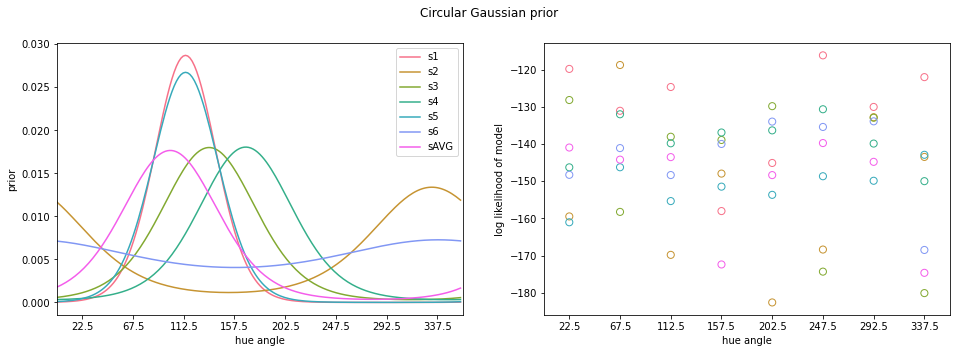

In [7]:
# prior_type = '_gauss_2peak_ewk_prior'
prior_type = '_gauss_prior'


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plt.suptitle("Circular Gaussian prior")

params_list = []
optm_prior_list = []
loglik_list = []
for idx, sub in enumerate(sub_list):
    prior_path = f"{model_path}/{sub}/{sub}{prior_type}_optm.json"
    loglik_path =  f"{model_path}/{sub}/{sub}{prior_type}_simul_log_liks.npy"
    with open (prior_path) as f:
        prior_sub = json.load(f)
    params_list.append(prior_sub["params"])
    optm_prior_list.append( prior_sub["prior"])
    params_sub = prior_sub["params"]
    optm_prior_sub = prior_sub["prior"]
    loglik = np.load(loglik_path, allow_pickle=True)
    if sub == 'sAVG':
        loglik = loglik / (len(sub_list) - 1)
    loglik_list.append(loglik)
    
    ax[0].plot(x_grid, optm_prior_sub, c=sub_colors[idx], label=sub)
    ax[0].set_xlim([0, 360])
    ax[0].set_xticks(stim_list)
    ax[0].set_ylabel('prior')
    ax[0].set_xlabel('hue angle')
    ax[0].legend()

    ax[1].scatter(stim_list, loglik, marker='o', s=50, edgecolors=sub_colors[idx], facecolors='none', label=sub)
    ax[1].set_xlim([0, 360])
    ax[1].set_xticks(stim_list)
    ax[1].set_ylabel('log likelihood of model')
    ax[1].set_xlabel('hue angle')

loglik_list = np.array(loglik_list)
# ax[1].scatter(stim_list,  np.mean(loglik_list, axis=0), marker="s", s=50, edgecolors='gray', facecolors='none')
# ax[1].errorbar(stim_list, np.mean(loglik_list, axis=0), np.std(loglik_list, axis=0), ls='none', color='gray', capsize=6)

plt.show()

## Show bootstrapping priors

In [ ]:
sns.lineplot(data=optm_prior_sub, x='Hue Angle', y='Prior', hue='sub')

### Descriptive results of prior peak locations

In [19]:
from scipy import stats

btrp_priors = pd.read_csv(f"{model_path}/gauss_prior_btrp100.csv")

# add boostrap index label
btrp_priors['i_btrp'] = np.tile(np.repeat(np.arange(1, 101, 1), len(x_grid)), 7)

# find idx where the max value is in each boostrap prior for each subject
# btrp_priors_peakidx = btrp_priors.groupby(['sub', 'i_btrp'])['Prior'].idxmin().reset_index()
btrp_priors_peakidx = btrp_priors.groupby(['sub', 'i_btrp'])['Prior'].idxmax().reset_index()

# find the hue angle has the max value in each boostrap prior for each subject
btrp_priors_peakloc = btrp_priors.loc[btrp_priors_peakidx.Prior.values, ['sub', 'Hue Angle']]

# convert hue angles to radian and do circular stats
btrp_priors_peakloc['Hue Angle rad'] = btrp_priors_peakloc['Hue Angle']/180. * np.pi
mbtrp_priors_peakloc = btrp_priors_peakloc.groupby('sub')['Hue Angle rad'].agg([stats.circmean, stats.circstd]).reset_index()

# convert hue angles back to degrees
mbtrp_priors_peakloc['Hue Angle mean'] = mbtrp_priors_peakloc['circmean'] /np.pi * 180
mbtrp_priors_peakloc['Hue Angle std'] = mbtrp_priors_peakloc['circstd'] /np.pi * 180
mbtrp_priors_peakloc['se'] = mbtrp_priors_peakloc['circstd']/np.sqrt(100)

mbtrp_priors_peakloc.to_csv((f"{model_path}/gauss_prior_btrp100_peakloc.csv"))
mbtrp_priors_peakloc

,sub,circmean,circstd,Hue Angle mean,Hue Angle std,se
0,s1,1.966634,0.037668,112.679827,2.158189,0.003767
1,s2,6.008731,0.288856,344.274938,16.550210,0.028886
2,s3,2.366234,0.110904,135.575224,6.354319,0.011090
3,s4,2.814814,0.318920,161.276952,18.272789,0.031892
4,s5,1.985141,0.018896,113.740227,1.082688,0.001890
5,s6,5.919631,0.178625,339.169866,10.234475,0.017863
6,sAVG,2.010523,0.348001,115.194500,19.939003,0.034800


In [17]:
f"{np.rad2deg(stats.circmean(mbtrp_priors_peakloc['circmean']))} +/- {np.rad2deg(stats.circstd(mbtrp_priors_peakloc['circmean']))}"
# f"{np.rad2deg(stats.circmean(mbtrp_priors_peakloc['circmean']))} +/- {np.rad2deg(stats.circstd(mbtrp_priors_peakloc['circmean']))/np.sqrt(7)}"

'107.31253848388174 +/- 70.46193521624231'

In [15]:
# Simply check the mean of 100 boostrapping priors

mbtrp_priors = pd.read_csv(f"{model_path}/gauss_prior_btrp100_mean.csv")
mbtrp_priors.loc[mbtrp_priors.groupby(['sub'])['Prior'].idxmax().values, ['sub', 'Hue Angle']]

,sub,Hue Angle
56,s1,112.0001
356,s2,352.0001
429,s3,138.0001
622,s4,164.0001
777,s5,114.0001
1070,s6,340.0001
1136,sAVG,112.0001


# Predict cross-noise data with recovered priors 

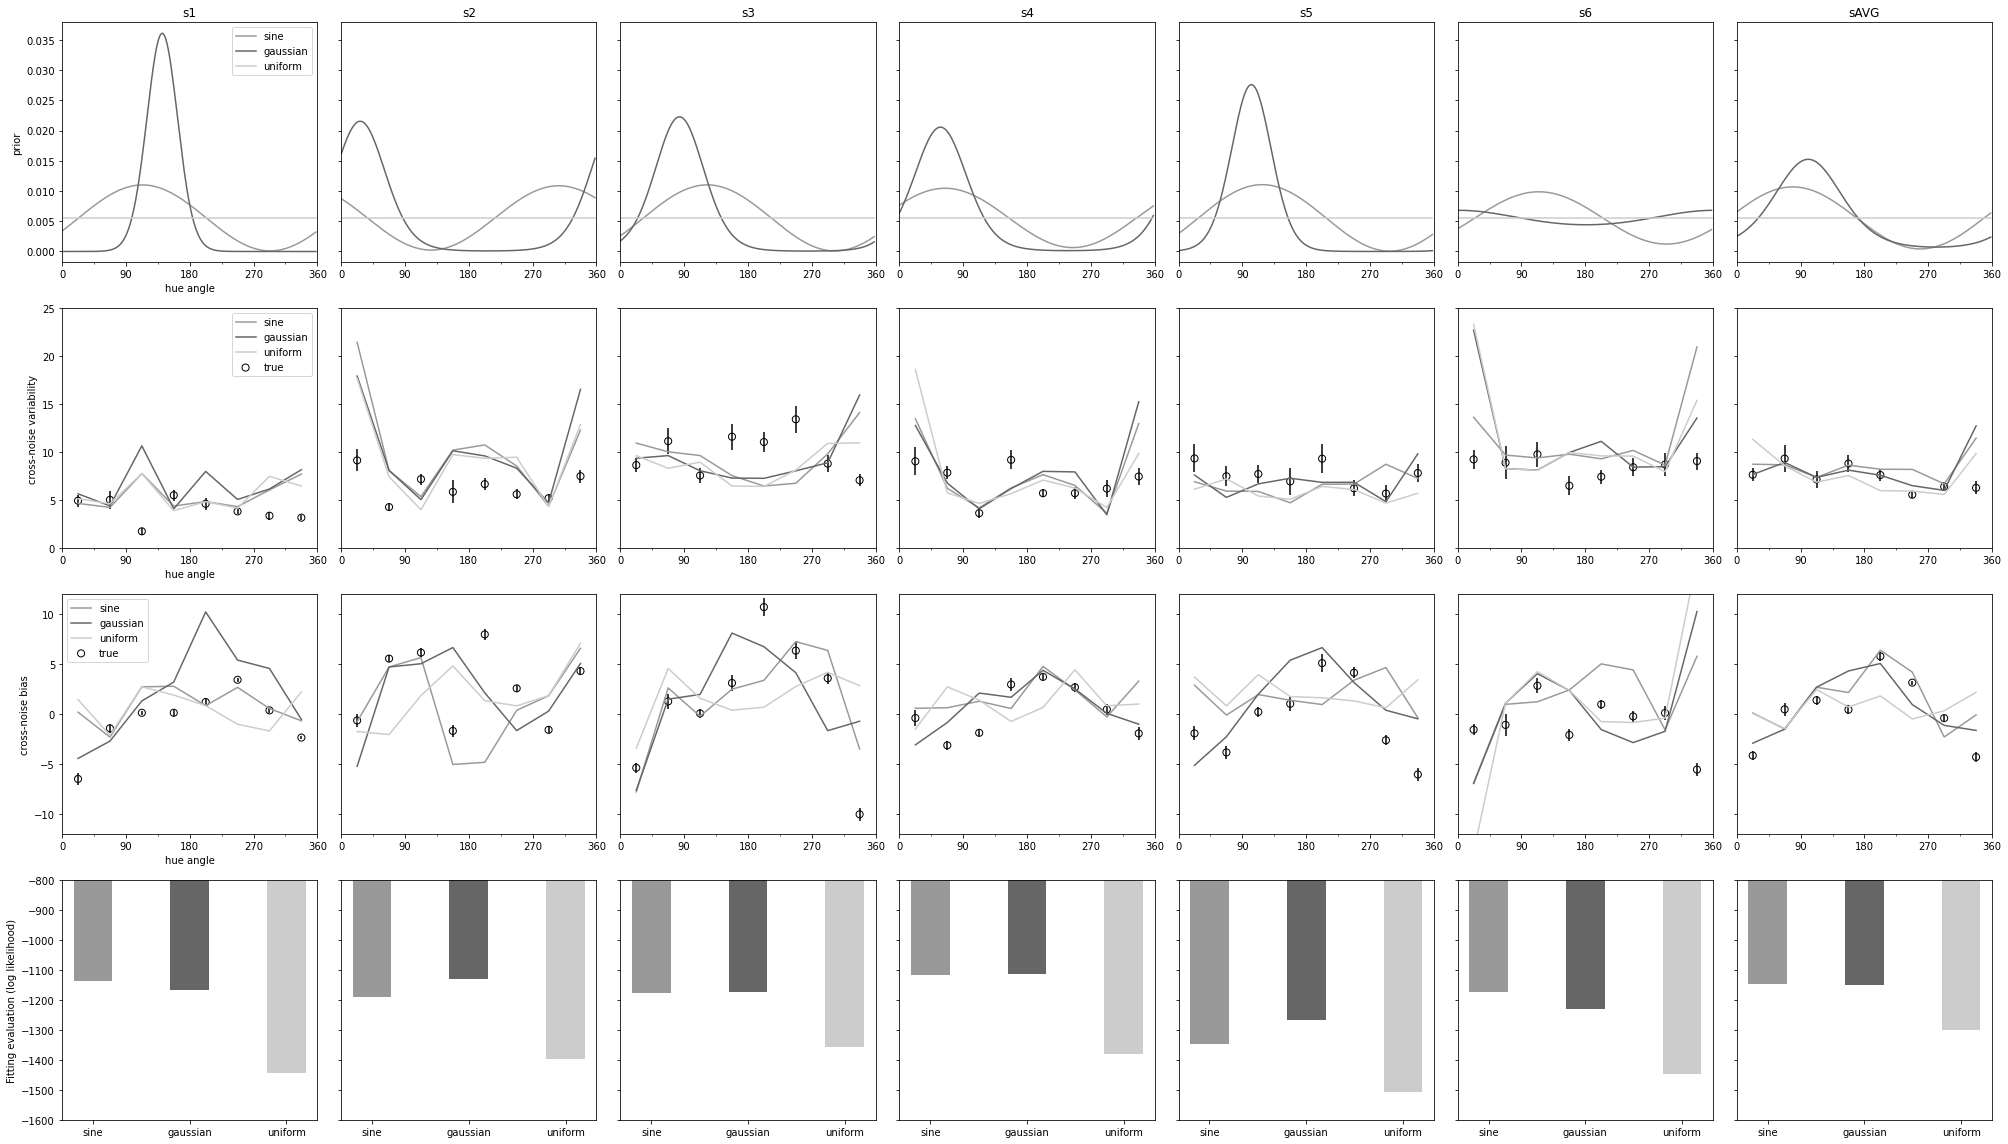

In [ ]:
sub_list = ['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG']
stim_list = np.linspace(22.5, 337.5, 8, endpoint=True)
all_lh_data = pd.read_csv('data/all_sel_data.csv').query('condition == "LH"')
all_lh_estimates = pd.read_csv('data_analysis/pf_estimates/all_estimates.csv').query('condition == "LH"')
avg_lh_estimates = pd.read_csv('data_analysis/pf_estimates/avg_estimates.csv').query('condition == "LH"')
flat_prior = prior_uniform(x_grid)

fig, ax = plt.subplots(ncols=len(sub_list), nrows=4, figsize=(4*len(sub_list), 4*4), sharey='row', sharex='row')
minor_ticks = np.linspace(0, 360, 8, endpoint=False)
major_ticks = [0, 90, 180, 270, 360]

for idx, sub in enumerate(sub_list):
    sub_path = "data_analysis/model_estimates/" + sub + '/' + sub

    if sub == 'sAVG':
        test_data = all_lh_data
        test_estimates = avg_lh_estimates
    else:
        sub_in_data = sub[0] + '0' + sub[1]
        test_data = all_lh_data.query('subject == @sub_in_data')
        test_estimates = all_lh_estimates.query('subject == @sub')

    # Sine priors
    with open (sub_path + '_sine_prior_optm.json') as f:
        optm_prior_sine = json.load(f)["prior"]
    with open (sub_path + '_sine_prior_simul_fit_res.pickle', 'rb') as f:
        sine_prior_simul_fit_res = pickle.load(f)
    sine_prior_loglik = np.load(sub_path + '_sine_prior_simul_log_liks.npy', allow_pickle=True)
    
    # Circular Gaussian priors
    with open (sub_path + '_gauss_prior_optm.json') as f:
        optm_prior_gaussian = json.load(f)["prior"]
    with open (sub_path + '_gauss_prior_simul_fit_res.pickle', 'rb') as f:
        gaussian_prior_simul_fit_res = pickle.load(f)
    gaussian_prior_loglik = np.load(sub_path + '_gauss_prior_simul_log_liks.npy', allow_pickle=True)
    
    # Row 1 - show prior
    ax[0, idx].set_title(sub)
    ax[0, idx].plot(x_grid, optm_prior_sine, c=(.6, .6, .6), label='sine')
    ax[0, idx].plot(x_grid, optm_prior_gaussian, c=(.4, .4, .4), label='gaussian')
    ax[0, idx].plot(x_grid, flat_prior, c=(.8, .8, .8), label='uniform')
    ax[0, idx].set_xlim([0, 360])
    ax[0, idx].xaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax[0, idx].xaxis.set_major_locator(plt.FixedLocator(major_ticks))
    plt.setp(ax[0, idx].xaxis.get_majorticklabels(), rotation=0)
    ax[0, 0].set_ylabel('prior')
    ax[0, 0].set_xlabel('hue angle')

    # Row 2 - predict JND
    ax[1, idx].scatter(stim_list, test_estimates['JND'], marker='o', s=50, edgecolors='black', facecolors='none', label='true')
    ax[1, idx].errorbar(stim_list,  test_estimates['JND'], test_estimates['JND_err'], ls='none', capsize=0, color='black')

    ax[1, idx].plot(stim_list, [f.params[1] for f in sine_prior_simul_fit_res.values], color=(.6, .6, .6), label='sine')
    ax[1, idx].plot(stim_list, [f.params[1] for f in gaussian_prior_simul_fit_res.values], color=(0.4, 0.4, 0.4), label='gaussian')

    ax[1, idx].xaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax[1, idx].xaxis.set_major_locator(plt.FixedLocator(major_ticks))
    plt.setp(ax[1, idx].xaxis.get_majorticklabels(), rotation=0)

    ax[1, idx].set_xlim([0, 360])
    ax[1, idx].set_ylim([0, 25])

    # Row 3 - predict PSE
    ax[2, idx].scatter(stim_list, test_estimates['PSE'], marker='o', s=50, edgecolors='black', facecolors='none', label='true')
    ax[2, idx].errorbar(stim_list,  test_estimates['PSE'], test_estimates['PSE_err'], ls='none', capsize=0, color='black')

    ax[2, idx].plot(stim_list, [f.params[0] for f in sine_prior_simul_fit_res.values], color=(.6, .6, .6), label='sine')
    ax[2, idx].plot(stim_list, [f.params[0] for f in gaussian_prior_simul_fit_res.values], color=(0.4, 0.4, 0.4), label='gaussian')

    ax[2, idx].xaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax[2, idx].xaxis.set_major_locator(plt.FixedLocator(major_ticks))
    plt.setp(ax[2, idx].xaxis.get_majorticklabels(), rotation=0)

    ax[2, idx].set_xlim([0, 360])
    ax[2, idx].set_ylim([-12, 12])


    # flat prior
    lik_l = np.load(sub_path + "_likelihoods_l.npy")
    lik_h = np.load(sub_path + "_likelihoods_h.npy")
    simul_res_flat, simul_fit_flat = simul_estimate(test_data, flat_prior, [lik_l, lik_h])
    ax[1, idx].plot(stim_list, [f.params[1] for f in simul_fit_flat.values],color=(0.8, 0.8, 0.8), label='uniform')
    ax[2, idx].plot(stim_list, [f.params[0] for f in simul_fit_flat.values],color=(0.8, 0.8, 0.8), label='uniform')

    sum_sine_prior_loglik = np.sum(sine_prior_loglik)
    sum_gaussian_prior_loglik = np.sum(gaussian_prior_loglik)
    sum_flat_prior_loglik = np.sum(each_loglik(test_lh_data, simul_res_flat, simul_fit_flat))

    if sub == 'sAVG':
        sum_sine_prior_loglik /= len(sub_list) - 1
        sum_gaussian_prior_loglik /= len(sub_list) - 1
        
    # Row 4: show likelihood
    ax[3, idx].bar(x=('sine', 'gaussian', 'uniform'), 
                   height = [sum_sine_prior_loglik, sum_gaussian_prior_loglik, sum_flat_prior_loglik],
                   width=0.4,
                   color=[(.6,.6,.6),(.4, .4, .4), (.8, .8, .8)])
    ax[3, idx].set_ylim(-1600, -800)

    ax[0, 0].legend()   
    ax[1, 0].legend() 
    ax[2, 0].legend() 
    ax[1, 0].set_xlabel('hue angle')
    ax[1, 0].set_ylabel('cross-noise variability')
    ax[2, 0].set_xlabel('hue angle')
    ax[2, 0].set_ylabel('cross-noise bias')
    ax[3, 0].set_ylabel('Fitting evaluation (log likelihood)')


plt.tight_layout() 
plt.show()
    

# Exploratory analysis: Hierarchical model of the prior 
Here I used `numpyro` to build a hierarchical model of priors instead of `pymc3`, as Pycharm could not compile theano properly on Mac.

Note that either `numpyro` or `pymc3` are not compatible with python 3.6 (jax error for numpyro, or theano error for pymc3). Switch to python 3.8 (env py38) before modeling.

In [3]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro import handlers
from numpyro.infer.reparam import CircularReparam
from jax import random, numpy
from sklearn.preprocessing import LabelEncoder
import arviz as az


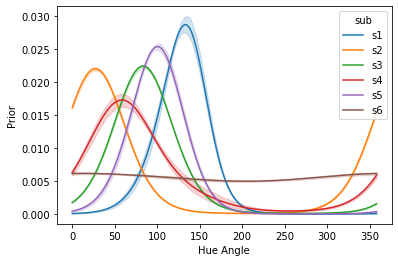

In [4]:
# Quick look glance at the prior estimates (sAVG not included)
btrp_priors = pd.read_csv("data_analysis/model_estimates/gauss_prior_btrp100.csv")
btrp_priors = btrp_priors.query("sub != 'sAVG'")
sns.lineplot(data=btrp_priors, x='Hue Angle', y='Prior', hue='sub')


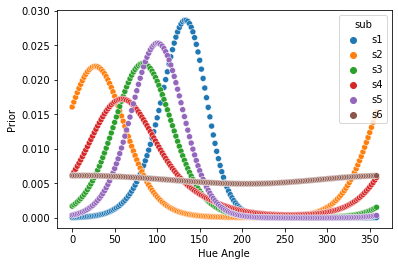

In [169]:
# Use prior averages for hierarchical model
btrp_priors_avg = btrp_priors.groupby(['sub', 'Hue Angle'])[['Prior']].mean().reset_index()
btrp_priors_avg.head()

sns.scatterplot(data=btrp_priors_avg, x='Hue Angle', y='Prior', hue='sub')

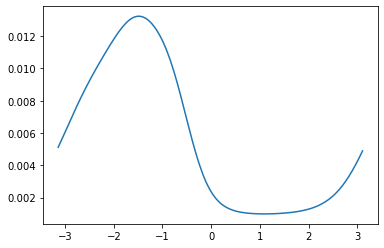

In [6]:
# Convert degree to radian [-pi, pi] (and vice versa later) before sampling
def rad2deg(r):
    return (r + np.pi) / np.pi * 180
def deg2rad(d):
    return d/ 180. * np.pi  - np.pi

# Check the conversion
plt.plot(deg2rad(x_grid), btrp_priors_avg.groupby('Hue Angle')['Prior'].mean())

In [95]:
def prior_circ_gaussian(x, mu, kappa):
    """
    A normalized von Mises model.
    """
    x_rad = x / 180 * np.pi
    y = np.exp(kappa * np.cos(x_rad - mu)) / (2 * np.pi * i0(kappa))
    return y/y.sum()

## Pooling model

In [30]:
# pooling model

def pooling_model(angles, priors_obs=None):
    m = numpyro.sample('m', dist.Uniform(-numpy.pi, numpy.pi))
    k = numpyro.sample('k', dist.HalfNormal(100))

    # Sampling error
    err = numpyro.sample('err', dist.HalfNormal(100))
    x_rad = deg2rad(angles)
    y = numpy.exp(k * numpy.cos(x_rad - m)) / (2 * numpy.pi * numpy.i0(k))
    priors_est = y/numpy.sum(y)

    # Sample estimates from Normal
    numpyro.sample('obs', dist.Normal(priors_est, err), obs=priors_obs)

numpyro.render_model(pooling_model, 
                    model_args=(btrp_priors_avg['Hue Angle'].values, btrp_priors_avg['Prior'].values), 
                    render_distributions=True)

mcmc_pool = MCMC(NUTS(pooling_model), num_warmup=1000, num_samples=1000)
mcmc_pool.run(random.PRNGKey(0), angles=btrp_priors_avg['Hue Angle'].values, priors_obs=btrp_priors_avg['Prior'].values)



sample: 100%|██████████| 2000/2000 [00:04<00:00, 425.67it/s, 3 steps of size 7.28e-01. acc. prob=0.93] 


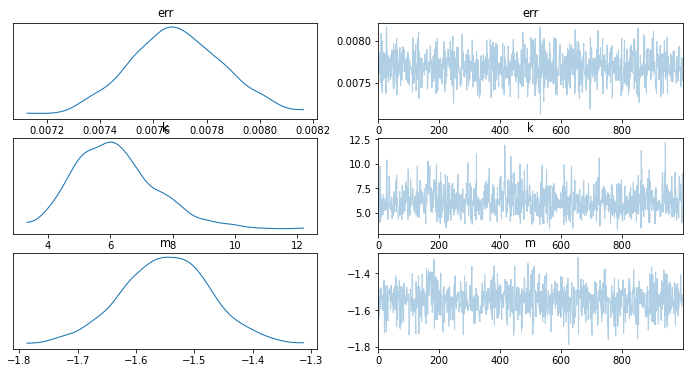

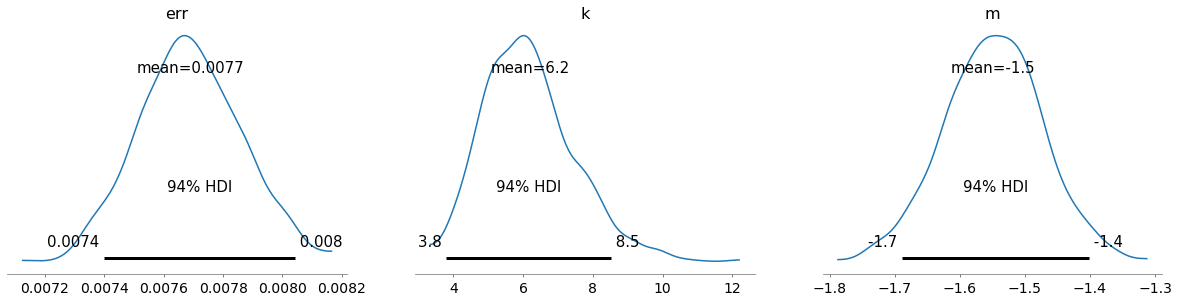

In [32]:
idata_pool = az.from_numpyro(mcmc_pool)
az.plot_trace(idata_pool, compact=True)
az.plot_posterior(idata_pool)
plt.show()

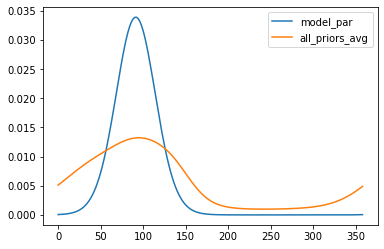

In [96]:
plt.plot(x_grid, prior_circ_gaussian(x_grid, mcmc_pool.get_samples()['m'].mean() + np.pi, 
                                                mcmc_pool.get_samples()['k'].mean()), label='model_par')
plt.plot(x_grid, btrp_priors_avg.groupby('Hue Angle')['Prior'].mean(), label='all_priors_avg')
plt.legend()
plt.show()

## Unpooling model

In [102]:
# @handlers.reparam(config={'m': CircularReparam()})

def unpooling_model(sub_idx, angles, priors_obs):

    n_sub = len(np.unique(sub_idx))

    with numpyro.plate("sub_i", n_sub):
        # m = numpyro.sample('m', dist.VonMises(0, 0.00001))
        m = numpyro.sample('m', dist.Uniform(-numpy.pi, numpy.pi))
        k = numpyro.sample('k', dist.HalfNormal(100))
        # k = numpyro.sample('k', dist.Uniform(0.0001, 30.))
        offset = numpyro.sample('offset', dist.Normal(0, 1.))


    # Error paramerter
    err = numpyro.sample('err', dist.HalfNormal(100))

    # Define the mean of estimated values
    x_rad = deg2rad(angles)
    y = numpy.exp(k[sub_idx] * numpy.cos(x_rad - m[sub_idx])) / (2 * numpy.pi * numpy.i0(k[sub_idx])) + offset[sub_idx]
    priors_est = y/numpy.sum(y)

    # Sample estimates from Von Mises
    with numpyro.plate("data", len(sub_idx)):
        numpyro.sample('obs', dist.Normal(priors_est, err), obs=priors_obs)


btrp_priors_avg = btrp_priors_avg.sort_values(by='sub')
sub_idx = LabelEncoder().fit_transform(btrp_priors_avg['sub'].values)

# numpyro.render_model(unpooling_model, 
#                     model_args=(sub_idx, btrp_priors_avg['Hue Angle'].values, btrp_priors_avg['Prior'].values), 
#                     render_distributions=True)

mcmc_unpool = MCMC(NUTS(unpooling_model), num_warmup=1000, num_samples=2000)
mcmc_unpool.run(random.PRNGKey(0), sub_idx=sub_idx, 
                                  angles=btrp_priors_avg['Hue Angle'].values, priors_obs=btrp_priors_avg['Prior'].values)


sample: 100%|██████████| 3000/3000 [00:13<00:00, 229.91it/s, 31 steps of size 1.24e-01. acc. prob=0.95]


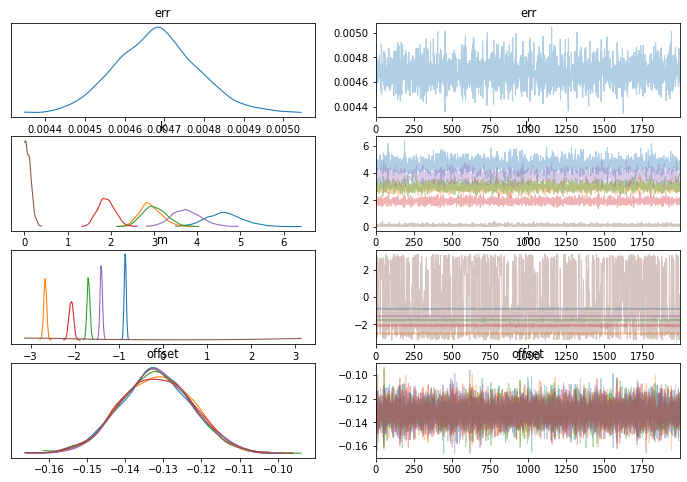

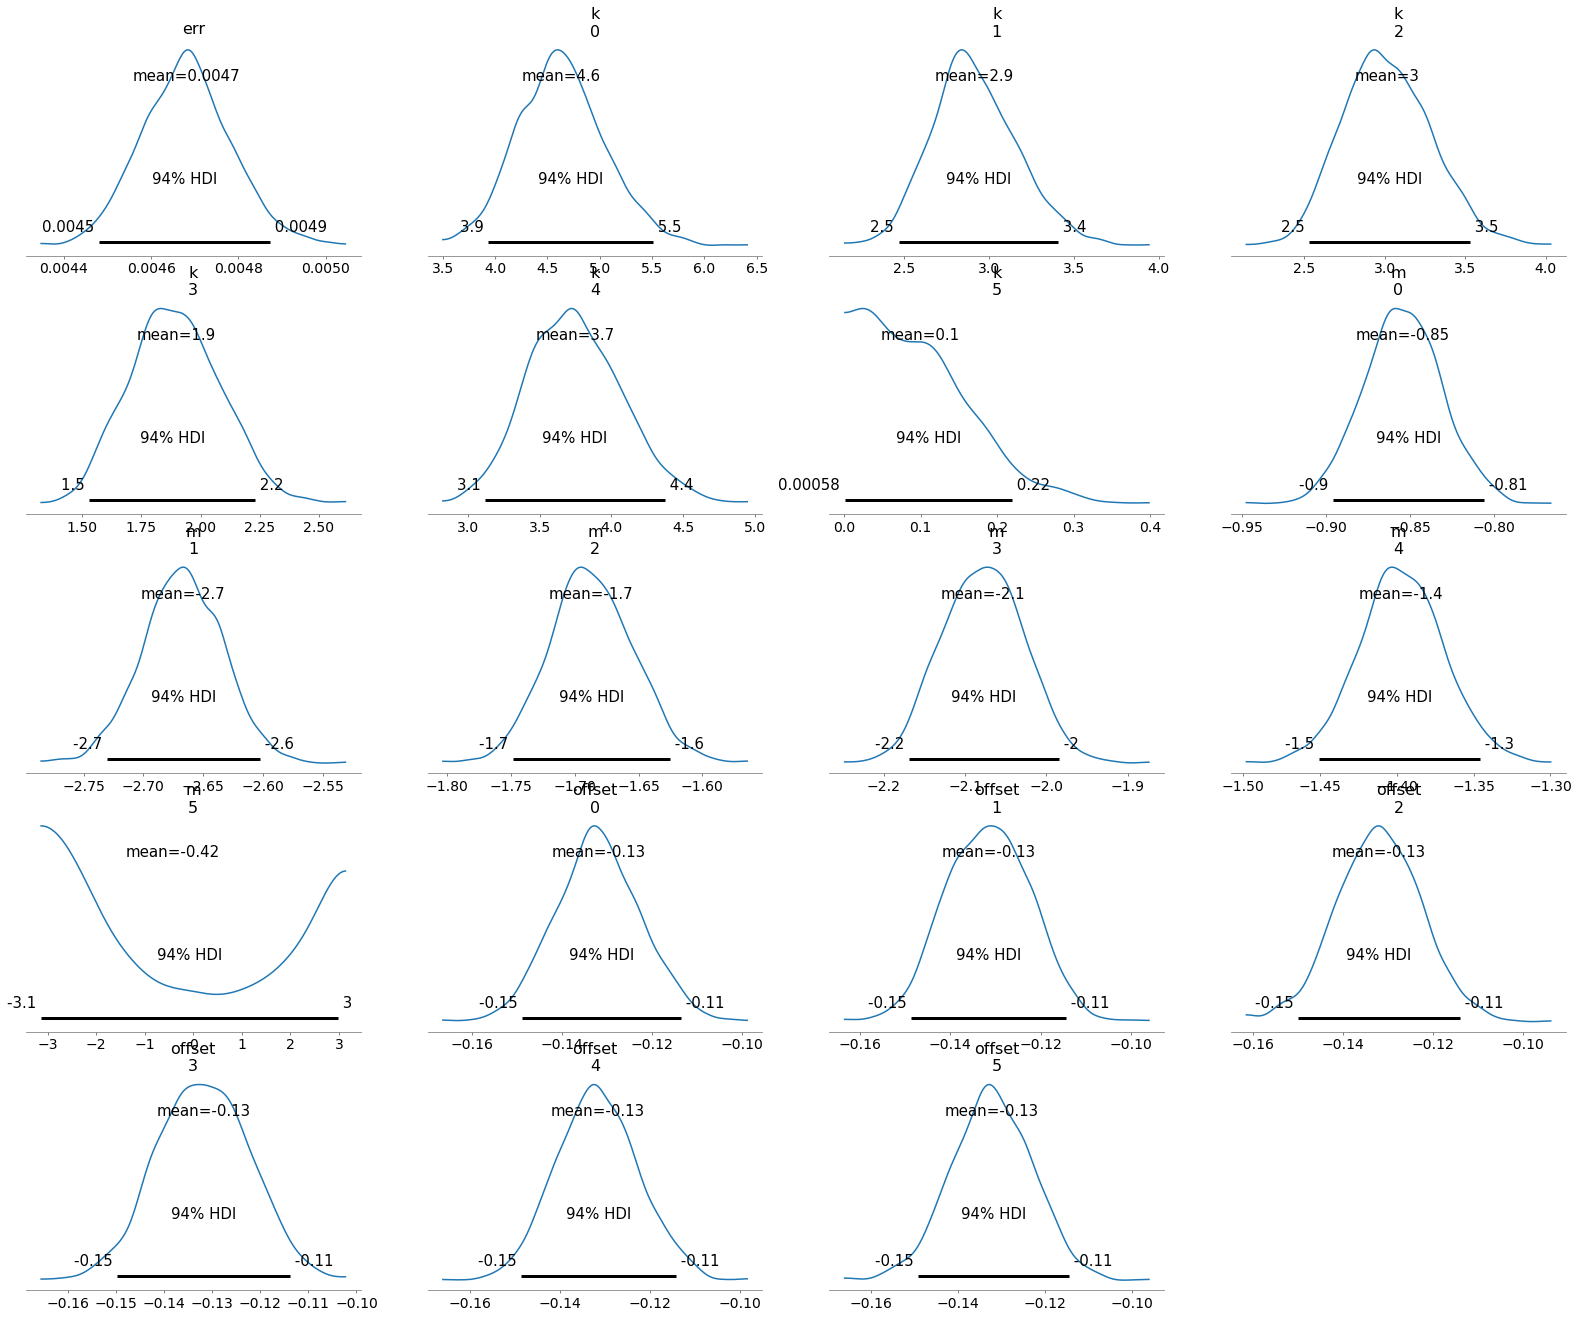

In [103]:
idata_unpool = az.from_numpyro(mcmc_unpool)
az.plot_trace(idata_unpool, compact=True)
az.plot_posterior(idata_unpool)
plt.show()

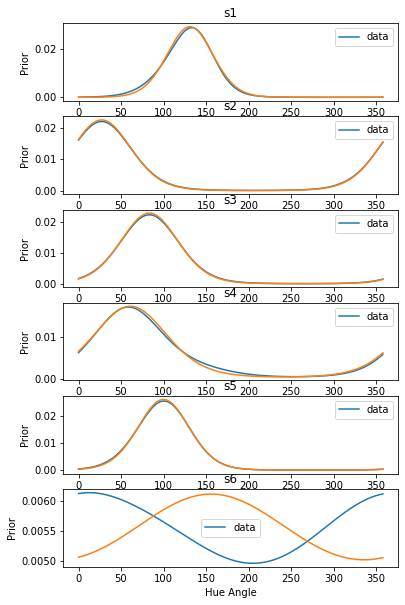

In [104]:
fig, axes = plt.subplots(figsize=[6, 10], nrows=6)
for i_s, s in enumerate(subs[:-1]):
    sns.lineplot(data=btrp_priors_avg.query("sub == @s"), x='Hue Angle', y='Prior', label='data', ax=axes[i_s])

    axes[i_s].plot(x_grid, prior_circ_gaussian(x_grid, mcmc_unpool.get_samples()['m'][:, i_s].mean() + np.pi, 
                                         mcmc_unpool.get_samples()['k'][:, i_s].mean()), label='model_par')
    axes[i_s].set_title(s)

## Partial pooling model

In [207]:
@handlers.reparam(config={'m': CircularReparam()})
def hierarchical_model(sub_idx, angles, priors_obs):

    # Hyperpriors for m and k
    mu_m = numpyro.sample('mu_m', dist.Uniform(-numpy.pi, numpy.pi))
    sigma_m = numpyro.sample('sigma_m', dist.HalfCauchy(5))

    # mu_k = numpyro.sample('mu_k', dist.Uniform(0.0001, 30))
    mu_k = numpyro.sample('mu_k', dist.HalfNormal(100))
    sigma_k = numpyro.sample('sigma_k', dist.HalfCauchy(5))

    # Partial pooling
    n_sub = len(np.unique(sub_idx))

    with numpyro.plate("sub_i", n_sub):
        m = numpyro.sample('m', dist.VonMises(mu_m, sigma_m))
        k = numpyro.sample('k', dist.Gamma(mu_k, sigma_k))
    
        # k = numpyro.sample('k', dist.Uniform(0.0001, 30.))
        offset = numpyro.sample('offset', dist.Normal(0, 1))

    # Error paramerter
    err = numpyro.sample('err', dist.HalfNormal(100))

    # Define the mean of estimated values
    x_rad = deg2rad(angles)
    y = numpy.exp(k[sub_idx] * numpy.cos(x_rad - m[sub_idx])) / (2 * numpy.pi * numpy.i0(k[sub_idx])) + offset[sub_idx]
    priors_est = y/numpy.sum(y)

    # Sample estimates from Von Mises
    with numpyro.plate("data", len(sub_idx)):
        # numpyro.sample('obs', dist.VonMises(priors_est, err), obs=priors_obs)
        numpyro.sample('obs', dist.Normal(priors_est, err), obs=priors_obs)

# Label subjects
btrp_priors_avg = btrp_priors_avg.sort_values(by='sub')
sub_idx = LabelEncoder().fit_transform(btrp_priors_avg['sub'].values)

angles = btrp_priors_avg['Hue Angle'].values
priors = btrp_priors_avg['Prior'].values

# numpyro.render_model(hierarchical_model, model_args=(sub_idx, angles, priors), render_distributions=True)

mcmc = MCMC(NUTS(hierarchical_model), num_warmup=1000, num_samples=2000)
mcmc.run(random.PRNGKey(0), sub_idx=sub_idx, angles=angles, priors_obs=priors)


sample: 100%|██████████| 3000/3000 [00:17<00:00, 167.41it/s, 31 steps of size 1.20e-01. acc. prob=0.94]


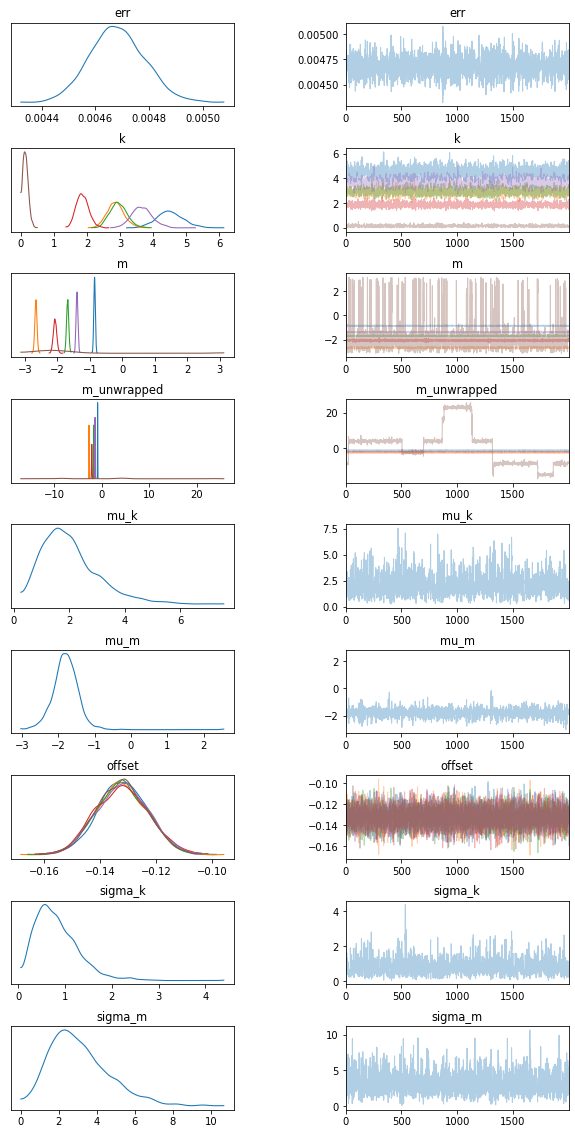

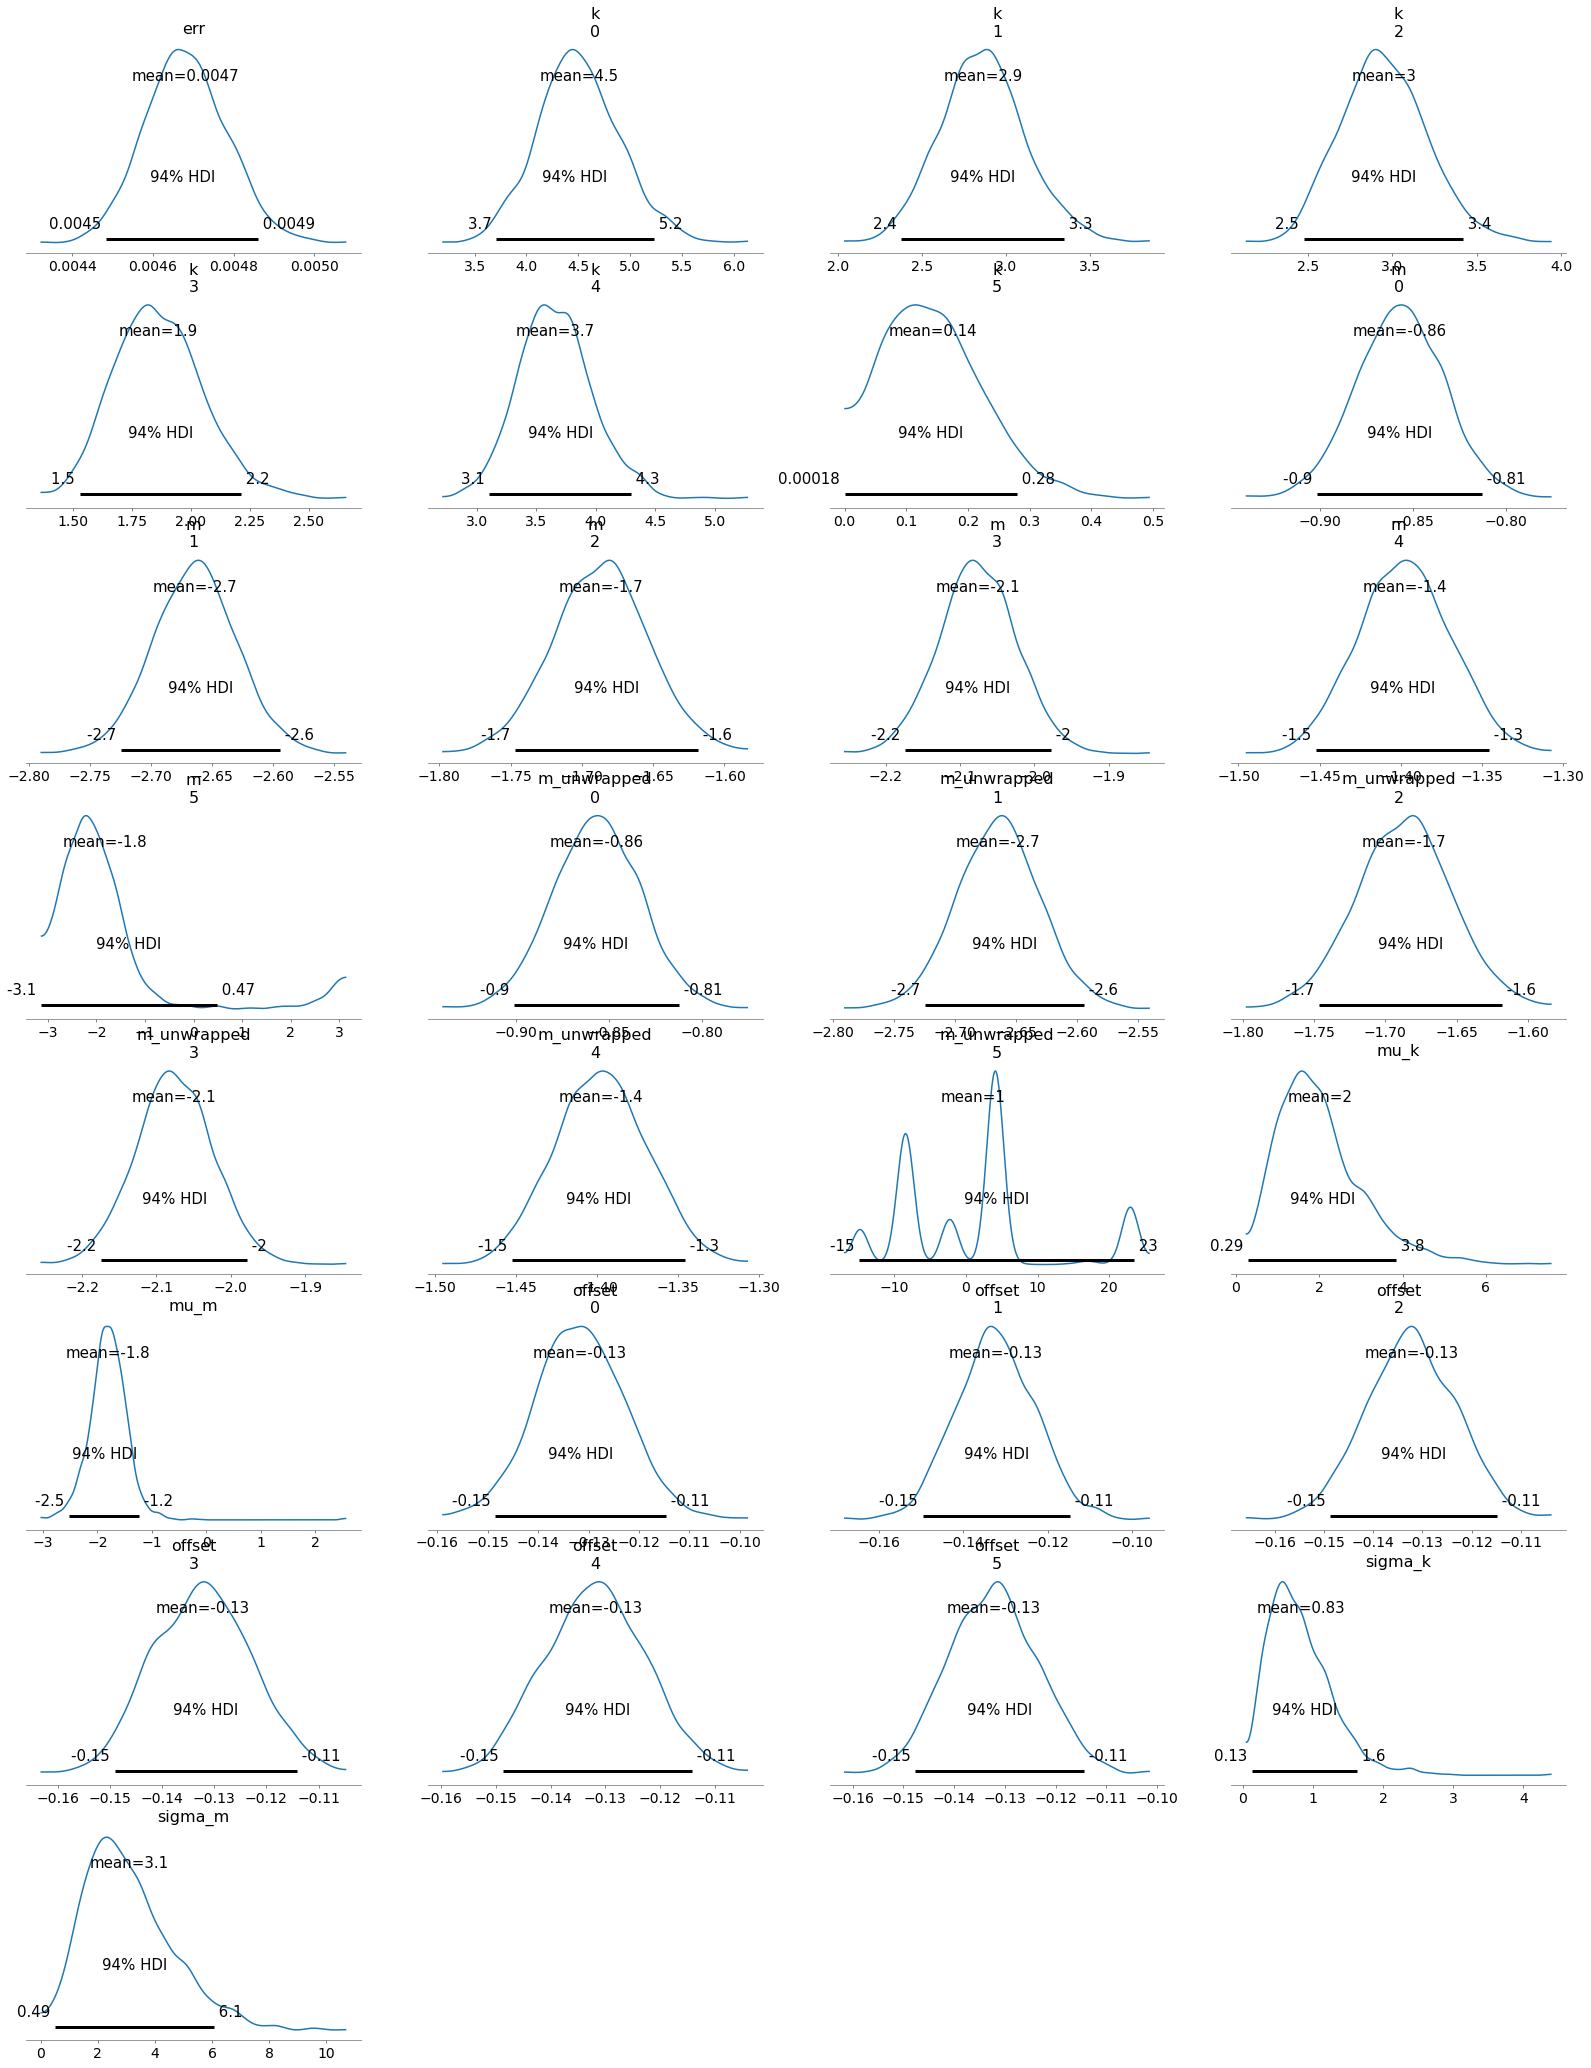

In [208]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata, compact=True, figsize=[10, 20])
plt.subplots_adjust(wspace=0.5, hspace=0.5)
az.plot_posterior(idata)
plt.show()


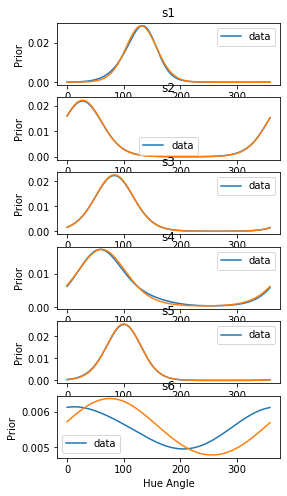

In [209]:
posterior_samples = mcmc.get_samples()
fig, axes = plt.subplots(figsize=[4, 8], nrows=6)
for i_s, s in enumerate(subs[:-1]):
    sns.lineplot(data=btrp_priors_avg.query("sub == @s"), x='Hue Angle', y='Prior', label='data', ax=axes[i_s])

    axes[i_s].plot(x_grid, prior_circ_gaussian(x_grid, posterior_samples['m'][:, i_s].mean()+np.pi, 
                                         posterior_samples['k'][:, i_s].mean()), label='model_par')
    axes[i_s].set_title(s)
                                


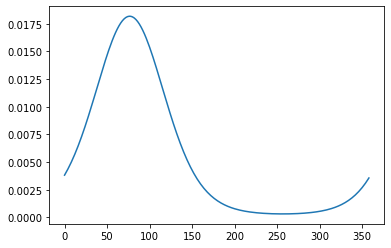

In [210]:
posterior_samples = mcmc.get_samples()
mu_m = posterior_samples['mu_m'].mean() + np.pi
mu_k = posterior_samples['mu_k'].mean()
plt.plot(x_grid, prior_circ_gaussian(x_grid, mu_m, mu_k))
plt.show()

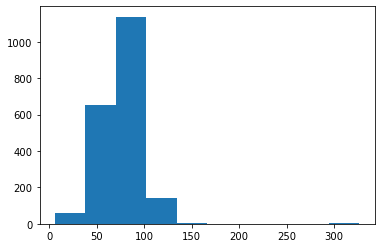

In [226]:
# distribution of mu_m
plt.hist(rad2deg(posterior_samples['mu_m']))
# plt.hist(rad2deg(np.random.vonmises(posterior_samples['mu_m'].mean(), posterior_samples['sigma_m'].mean(), 2000)))
plt.show()

In [227]:
rad2deg(posterior_samples['mu_m'].mean())

DeviceArray(76.63247, dtype=float32)

In [191]:
from numpyro.infer import Predictive
predictive = Predictive(hierarchical_model, mcmc.get_samples(), return_sites=['sigma', 'obs'])
samples_predictive = predictive(random.PRNGKey(0), 
                                sub_idx, angles, None)

cmp = btrp_priors_avg.copy()
cmp['pred_mean'] = samples_predictive['obs'].T.mean(axis=1)
cmp['pred_std'] = samples_predictive['obs'].T.std(axis=1)


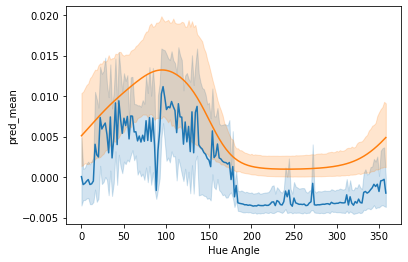

In [215]:
# Predict vs. Observed (all subjects)
sns.lineplot(data=cmp, x='Hue Angle', y='pred_mean')
sns.lineplot(data=cmp, x='Hue Angle', y='Prior')

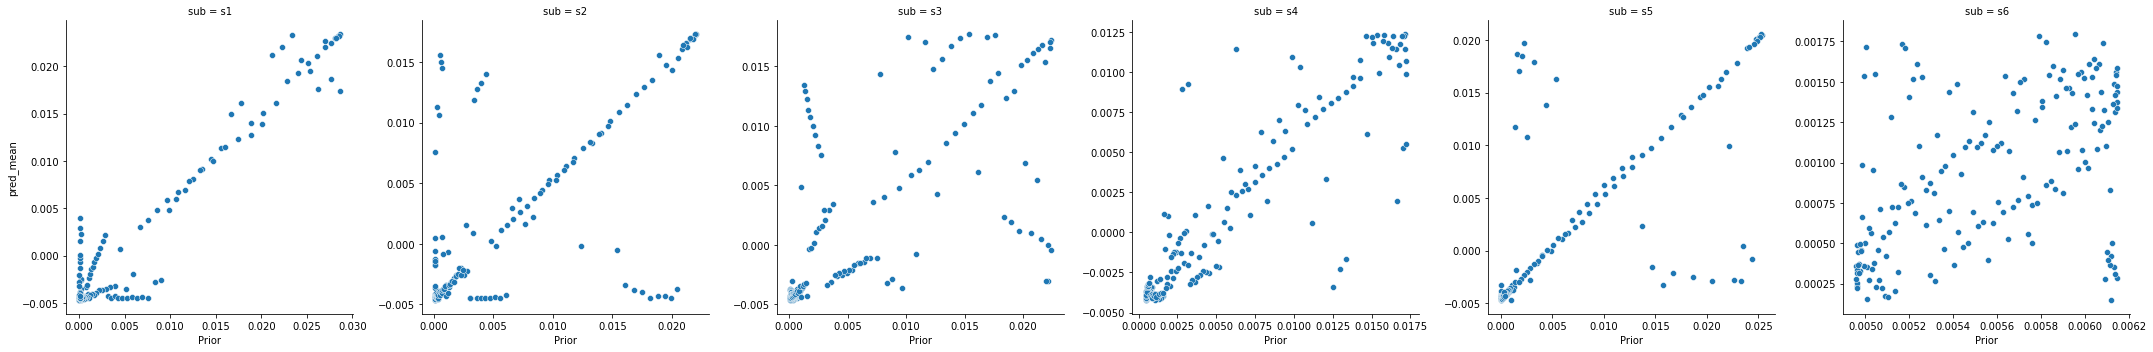

In [216]:
# Predict vs. Observed (single subjects)
sns.relplot(data=cmp, x='Prior', y='pred_mean', col='sub', facet_kws=dict(sharey=False, sharex=False))
plt.show()

In [101]:
# Pymc version
# import pymc3 as pm
# import arviz as az
# import theano.tensor as tt

# pi = 3.1415926


# def prior_circ_gaussian(x, mu, kappa):
#     """
#     A von Mises model for the prior.
#     Note for pymc, theano-style replace scipy and numpy styles.
#     :param pars:
#     :return: normalized prior
#     """
#     x_rad = x / 180. * pi
#     y = tt.exp(kappa * tt.cos(x_rad - mu)) / (2 * pi * tt.i0(kappa))
#     return y/y.sum()

# with pm.Model() as hierarchical_model:
#     # Hyperparameter of mu and kappa

#     mu_m = pm.Uniform('mu_m', 0., 359.)  
#     sigma_m = pm.HalfNormal('sigma_m', 100.)

#     mu_k = pm.Uniform('mu_k', 1, 20) 
#     sigma_k = pm.HalfNormal('sigma_k', 100.)

#     m = pm.VonMises('m', mu_m, sigma_m, shape=n_sub)
#     k = pm.VonMises('k', mu_k, sigma_k, shape=n_sub)  
#     # k = pm.HalfNormal('k', 40., shape=n_sub)  
#     # k = pm.HalfNormal('k', 40., shape=n_sub)  

#     err = pm.HalfNormal('err', sigma=100) 
     
#     # pred = pm.VonMises('pred', mu=prior_circ_gaussian(hues, m, k), kappa=err, observed=priors)
#     pred = pm.VonMises('pred', mu=prior_circ_gaussian(hues, m[sub_index], k[sub_index]), kappa=err, observed=priors)

#     trace = pm.sample(10, tune=1000,cores=2) 

# az.plot_trace(trace, var_names=["mu_m", "mu_k"])

<ipython-input-101-0f5192b7a64a>:38: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10, tune=1000,cores=2)
Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [err, k, m, sigma_k, mu_k, sigma_m, mu_m]


Sampling 2 chains for 1_000 tune and 10 draw iterations (2_000 + 20 draws total) took 1351 seconds.
/Users/su/anaconda3/envs/py38/lib/python3.8/site-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


# Exploratory analysis: Predict bias from discriminability using the law in Wei2017-mm

## The lawful relation
a direct functional relation between perceptual bias and discrimination threshold in the form of 

$$
b(\theta) \propto (D(\theta)^2)'
$$


Text(0, 0.5, 'Relative Bias (deg)')

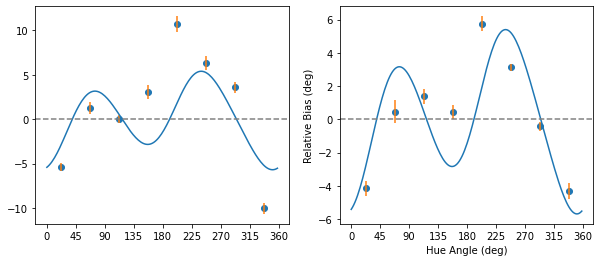

In [28]:
from data_analysis.estimate_likelihood import rect_sin, mixed_sin

from scipy.misc import derivative

# model_path = 'data_analysis/model_estimates'

# def rect_sin_square(x, a, b):
#     """
#     Rectified sine function.

#     param x:    angle in degree
#     param a:    amplitude
#     param b:    offset
#     """
#     shift = -112  # peak at 112
#     rsin = a * abs(np.sin((x + shift) * np.pi / 180.0)) + b
#     return rsin**2

# def rect_sin_derivative(x, pars):
#     return derivative(rect_sin_square, x, dx=1/2/np.pi, args=pars)


model_path = 'data_analysis/model_estimates_v2'

def mixed_sin_square(x, s1, s2, a, b):
    """
    Mixed sine function
    param x:       angle in degree
    param s1, s2:  shifts in degree
    param a:  amplitudes
    param b:  offsets
    """
    msin = a * (np.sin((x + s1) * np.pi / 90.0) + np.sin((x + s2) * np.pi / 180.0)) + b
    return msin**2

def mixed_sin_derivative(pars, x):
    return derivative(mixed_sin_square, x, dx=1/2/np.pi, args=pars)

# def mixed_sin_derivative(pars):
#     """
#     x: angle in degree
#     s1, s2: shift in degree
#     a: amplitude
#     b: offset
#     """
#     a, b = pars[0], pars[1]
#     # x = stim_list
#     x = x_grid
#     # rect sine = |a * sin (x - 112) + b|
#     rect_sin = a * abs(np.sin(np.deg2rad(x-112))) + b
#     return a * 


# model_path = 'data_analysis/model_estimates_v2'

# def mixed_sin_derivative(pars):
#     """
#     x: angle in degree
#     s1, s2: shift in degree
#     a: amplitude
#     b: offset
#     """
#     s1, s2, a, b = pars[0], pars[1], pars[2], pars[3]
#     # x = stim_list
#     x = x_grid
#     # mixed sine = a * (sin (2x + s1) + sin (x + s2)) + b
#     x1 = np.deg2rad(x+s1)
#     x2 = np.deg2rad(x+s2)
#     return a * (4 * np.sin(np.deg2rad(2*x+s1)) * np.cos(x1) + 2 * np.sin(x2) * np.cos(x2)) 



# Load jnds 
fit_jnd_l_pars = []
fit_jnd_h_pars = []
fit_jnd_lh_pars = []

for sub in ['s1', 's2', 's3', 's4', 's5', 's6', 'sAVG']:
    pickle_l, pickle_h = f"{model_path}/{sub}/{sub}_jnd_fit_l.pickle", f"{model_path}/{sub}/{sub}_jnd_fit_h.pickle", 
    pickle_lh = f"{model_path}/{sub}/{sub}_jnd_fit_lh.pickle"

    with open(pickle_l, 'rb') as f:
        fit_jnd_l = pickle.load(f)
    with open(pickle_h, 'rb') as f:
        fit_jnd_h = pickle.load(f)
    with open(pickle_lh, 'rb') as f:
        fit_jnd_lh = pickle.load(f)

    fit_jnd_l_pars.append(fit_jnd_l['params'])
    fit_jnd_h_pars.append(fit_jnd_h['params'])
    fit_jnd_lh_pars.append(fit_jnd_lh['params'])

fit_jnd_l_pars = np.array(fit_jnd_l_pars)
fit_jnd_h_pars = np.array(fit_jnd_h_pars)
fit_jnd_lh_pars = np.array(fit_jnd_lh_pars)



bias_by_law = np.apply_along_axis(mixed_sin_derivative, 1, fit_jnd_lh_pars, x=x_grid) 
# bias_by_law = np.apply_along_axis(mixed_sin_derivative, 1, fit_jnd_h_pars, x=x_grid)  - np.apply_along_axis(mixed_sin_derivative, 1, fit_jnd_l_pars, x=x_grid)

bias_by_law = - bias_by_law * 10
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

# [plt.plot(x_grid, rb, label=s) for rb, s in zip(bias_by_law, subs)]
# plt.plot(x_grid, np.mean(bias_by_law, axis=0))
ax[0].plot(x_grid, bias_by_law[-1, :])  # sAVG
ax[0].scatter(stim_list, all_estimates.query("subject == 's3' and condition=='LH'")['PSE']) #, marker=cond_cfg['markers']['LH'], s=marker_size,linewidth=marker_linewidth, edgecolors='black', facecolors='none', label='true',  zorder=2)  
ax[0].errorbar(stim_list,  all_estimates.query("subject == 's3' and condition=='LH'")['PSE'],  all_estimates.query("subject == 's3' and condition=='LH'")['PSE_err'], ls='none',)# linewidth=marker_linewidth, capsize=0, color='black',  zorder=2))
ax[0].set_xticks(np.arange(0, 360+45, 45))
ax[0].axhline(0, ls='--', color='gray')
plt.xlabel('Hue Angle (deg)')
plt.ylabel('Relative Bias (deg)')

ax[1].plot(x_grid, bias_by_law[-1, :])  # sAVG
ax[1].scatter(stim_list, avg_estimates.query("condition=='LH'")['PSE']) #, marker=cond_cfg['markers']['LH'], s=marker_size,linewidth=marker_linewidth, edgecolors='black', facecolors='none', label='true',  zorder=2)  
ax[1].errorbar(stim_list,  avg_estimates.query("condition=='LH'")['PSE'],  avg_estimates.query("condition=='LH'")['PSE_err'], ls='none',)# linewidth=marker_linewidth, capsize=0, color='black',  zorder=2))
ax[1].set_xticks(np.arange(0, 360+45, 45))
ax[1].axhline(0, ls='--', color='gray')
plt.xlabel('Hue Angle (deg)')
plt.ylabel('Relative Bias (deg)')
